In [67]:
import pandas as pd
import numpy as np
import json
import matplotlib
import logging
import os
import nevergrad as ng
from concurrent import futures
import time
import networkx as nx
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
import sklearn.svm as svm
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

logger = logging.getLogger(__name__)
logging.basicConfig(level=os.environ.get("LOGLEVEL", "WARNING"))

import sys
sys.path.append("../common") 

from common import *
from helpers import *

In [68]:
df = make_df_from_sheet(r"data/GWTC_2021_Master.csv") # read the file
df.head(n=1)

id (Event ID) commonName (Event Name)          Classification  version  \
0   GW150914-v3                GW150914  Black Hole (High Mass)        3   

  catalog.shortName         GPS  Mass_1_source (solar masses)  \
0  GWTC-1-confident  1126259462                          35.6   

   mass_1_source_upper_error  Mass_1_Upper Limit (solar masses)  \
0                        4.7                               40.3   

   mass_1_source_lower_error  ...  redshift_upper_limit           far  \
0                       -3.1  ...                  0.12  1.000000e-07   

   far_lower  far_upper  p_astro  p_astro_lower  p_astro_upper  \
0        NaN        NaN      1.0            NaN            NaN   

   final_mass_source  final_mass_source_lower  final_mass_source_upper  
0               63.1                     -3.0                      3.4  

[1 rows x 53 columns]

In [69]:
def filter_bh(df): 
    # returns indexes of bh items
    return df.Classification.str.contains("Black Hole")

def filter_ns(df):
    return df.Classification.str.contains("Neutron Star")

# Load the hierarchy

Change the hierarchy file here to change the ontology

/Users/akmb2/miniforge3/envs/gwpy-test/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


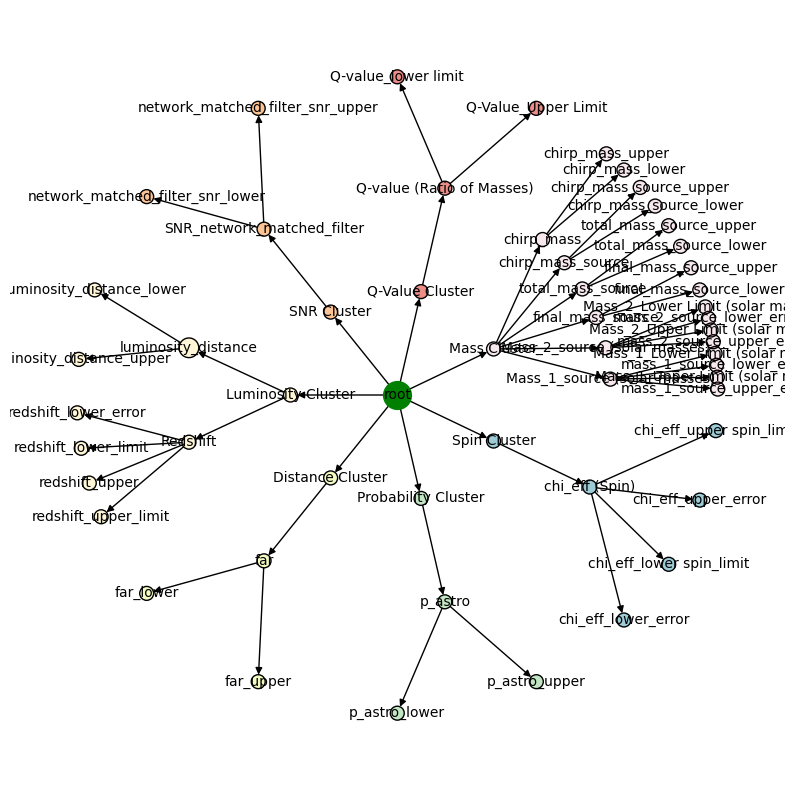

In [70]:
# load the heirarchy file.
from rktoolkit.functions.htg_transformers import BaseOntologyTransform
from rktoolkit.visualizers.util import draw_graph

hierarchy_file = r'data/gwtc_heirarchy_pretty.json'
# uncommment the below line for other file 
# hierarchy_file = r'data/new_heirarchy_for_rk_similarity.json'

hft = BaseOntologyTransform(mapping=json.load(open(hierarchy_file, "r")))
processed_df, y, alldf, ids = preprocess(df)

# plot the heirarchy
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
g = hft.transform(processed_df.iloc[0])
draw_graph(g , ax=ax, with_labels=True, minsize=100, alpha=100, emult=2, make_axis=False) 
os.makedirs("rendered", exist_ok=True)
plt.savefig("rendered/heirarchy_graph.png")

In [71]:
opts = {
    "chi_eff (Spin)": [-0.1, 0.1],
    "Q-value (Ratio of Masses)": [.01, .88]
}
import numbers
from rktoolkit.functions.filters import RangeFilter
from rktoolkit.functions.linkers import SimpleChildLinker

def make_linkers_and_filters(graph, opts={}):
    '''
    Defaults all filters to be a range filter. And the linker to be a simple child linker. 
    '''
    ENDL = " | " 
    filters, linkers = {}, {}
    for k, v in graph.nodes.items():
        if 'value' in v and isinstance(v['value'], numbers.Number):
            if v["id"] in opts:
                print("Set {:s} from options".format(v["id"]), end=ENDL)
            else:
                print("Set {:s} to default".format(v["id"]), end=ENDL)
            minv, maxv = opts.get(v["id"][0], 0), opts.get(v["id"][1], 1)
            filters[k] = RangeFilter(min=minv, max=maxv)        
    linkers['root'] = SimpleChildLinker()
    return filters, linkers

filters, linkers = make_linkers_and_filters(g, opts)

Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) from options | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_lower to default | Set luminosit

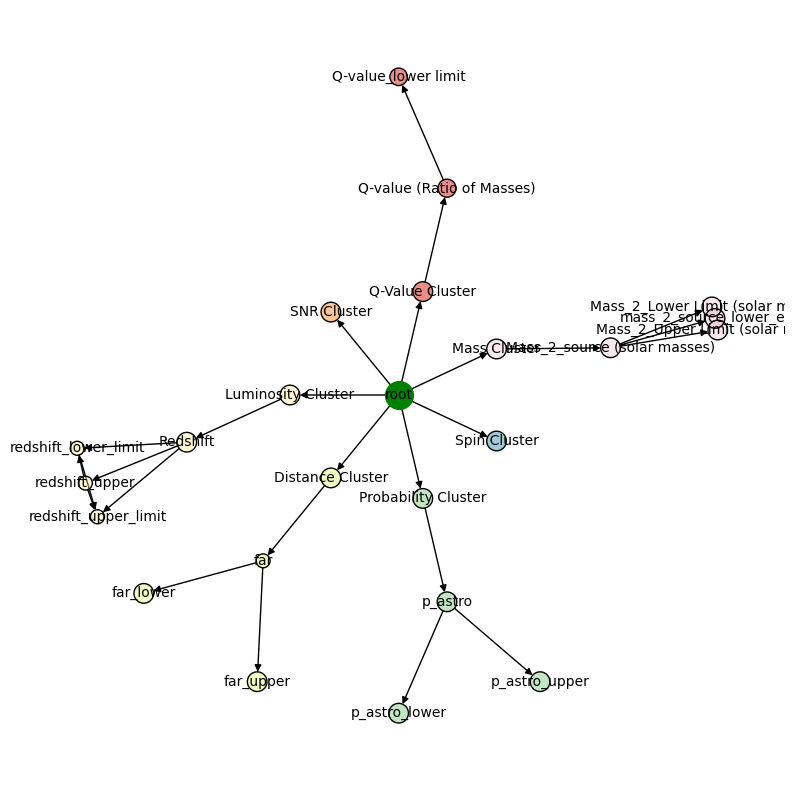

In [72]:
from rktoolkit.models.pipeline import RKPipeline 
from rktoolkit.visualizers.util import draw_rk_diagram
from rktoolkit.models.graph import Edge 

pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
g2 = pipeline.transform(g, is_base=False)
fig, ax = plt.subplots(figsize=(10,10))
draw_rk_diagram(g2, ax=ax, with_labels=True, minsize=100, alpha=100, emult=2, make_axis=False)  
plt.savefig("rendered/rk_graph1.png")

## Untuned Visualizations

Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) to default | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_lower to default | Set luminosity_

/Users/akmb2/miniforge3/envs/gwpy-test/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Average similarity of graphs pre tuned: 0.9281976722379561


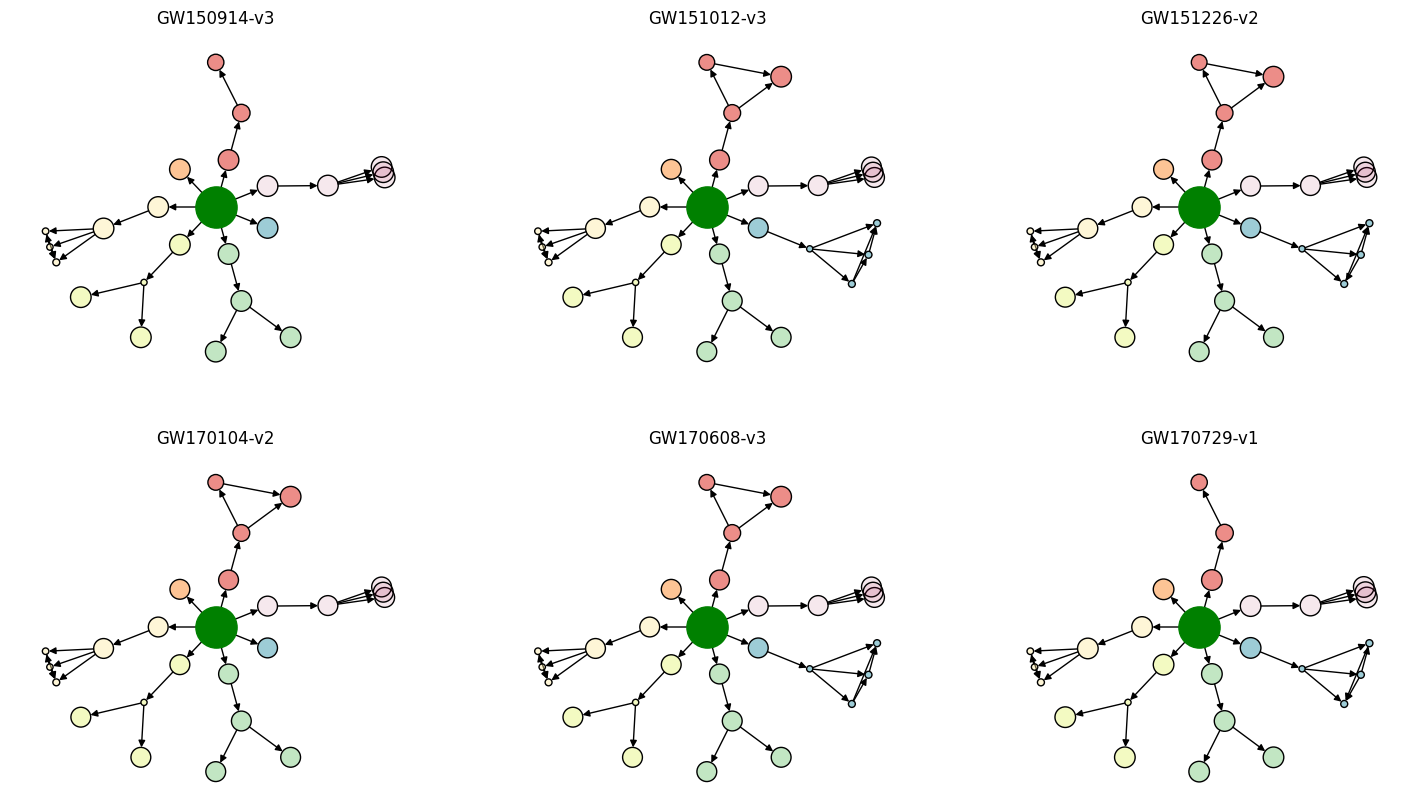

In [73]:
# completely untuned
f, l = make_linkers_and_filters(g, {})
n = 6
pipeline = RKPipeline(filter_map=f, linkage_map=l, structural_graph=g)
rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
mdist = compute_distance(processed_df)
distances = compute_distances(rkmodels, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

Average similarity of graphs pre tuned: 0.9281976722379561


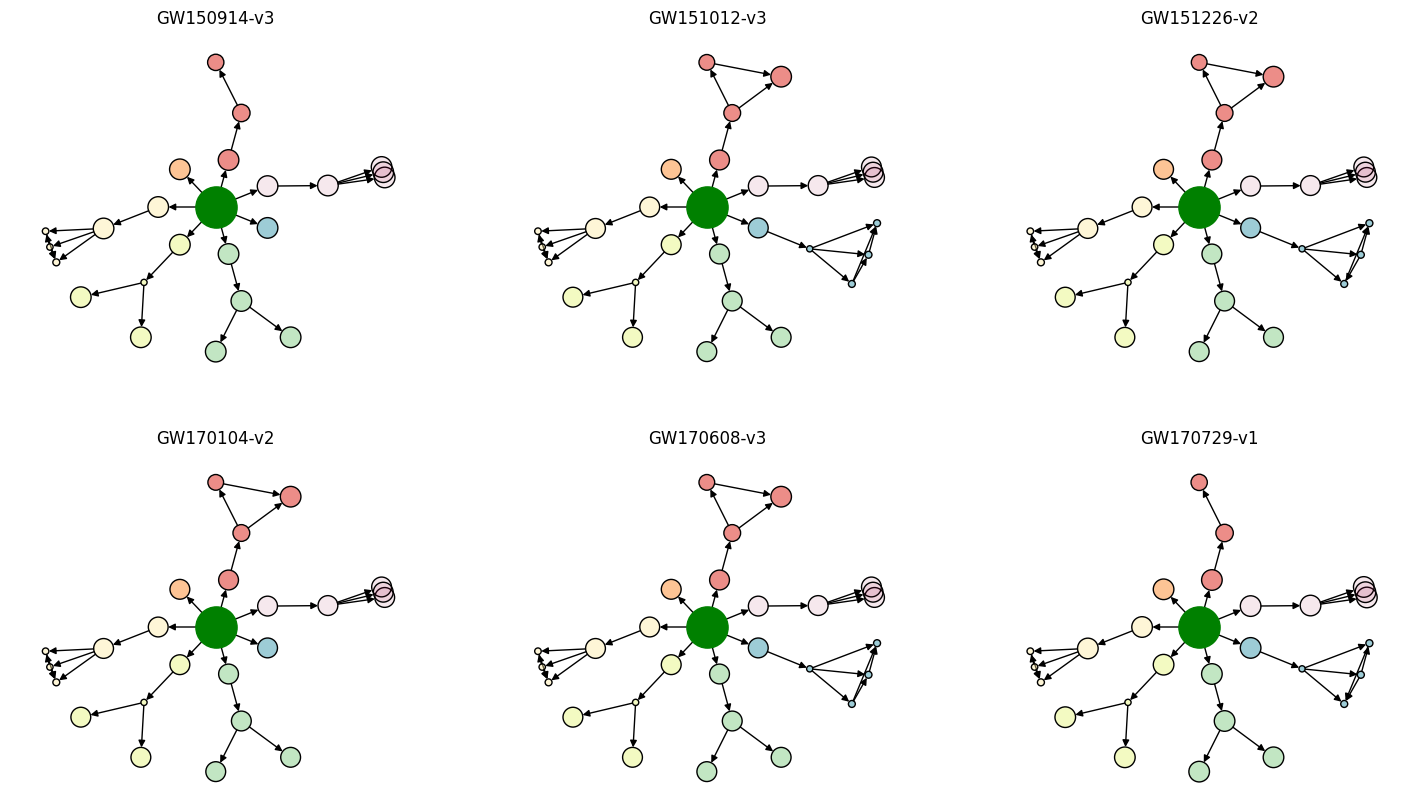

In [74]:
n = 6
pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
mdist = compute_distance(processed_df)
distances = compute_distances(rkmodels, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

In [75]:
selected_events = ["GW170729", "GW170817", "GW190814", "GW190521"]
subset_df = df[df["commonName (Event Name)"].isin(selected_events)]
label_df = df.iloc[subset_df.index]

def build_4_model(pipeline, title, filename):
    n = 4
    rkmodels = make_n_rkmodels(processed_df, alldf,hft, pipeline, n=n, indexes=list(subset_df.index))
    print("Processed {} rk models from {}".format(len(rkmodels), len(processed_df)))
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    
    plt.savefig("rendered/untuned_{}_{}.png".format(filename, n))
    plt.show()
    print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

## Tuning

Iteration: 00100. Loss: 0.95275320. ITime 7.16 seconds. Total time: 7.27
Iteration: 00200. Loss: 0.91857157. ITime 7.39 seconds. Total time: 14.67
Iteration: 00300. Loss: 0.92160131. ITime 7.59 seconds. Total time: 22.26
Iteration: 00400. Loss: 0.92028571. ITime 7.39 seconds. Total time: 29.65
Iteration: 00500. Loss: 0.91435869. ITime 7.51 seconds. Total time: 37.17
Iteration: 00600. Loss: 0.88182554. ITime 7.84 seconds. Total time: 45.01
Iteration: 00700. Loss: 0.87447438. ITime 7.63 seconds. Total time: 52.64
Iteration: 00800. Loss: 0.89539725. ITime 7.93 seconds. Total time: 60.57
Iteration: 00900. Loss: 0.85038898. ITime 10.27 seconds. Total time: 70.84
Iteration: 01000. Loss: 0.90606377. ITime 9.98 seconds. Total time: 80.82
Iteration: 01100. Loss: 0.88862196. ITime 8.24 seconds. Total time: 89.07
Iteration: 01200. Loss: 0.85391413. ITime 7.65 seconds. Total time: 96.71
Iteration: 01300. Loss: 0.89750386. ITime 7.78 seconds. Total time: 104.49
Iteration: 01400. Loss: 0.88452258. I

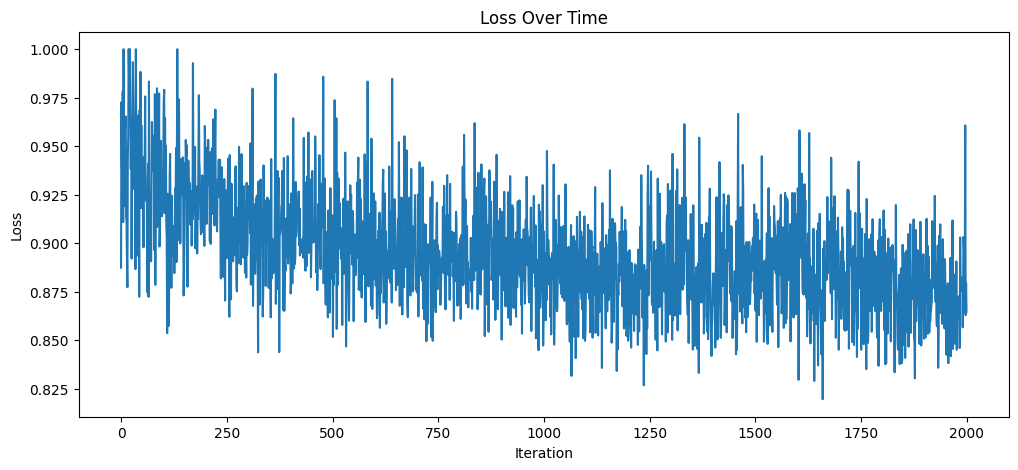

<Figure size 640x480 with 0 Axes>

In [76]:
w0 = pipeline.get_w()
weights, history = train(len(w0[0]), pipeline, processed_df, hft, mdist)
show(weights, history, pipeline, processed_df, hft, w0)

### Saving Weights and Loading Weights

In [79]:
def save_weights(directory="weights"):
    # overrides the weights file
    directory = "weights"
    if not os.path.exists(directory):
        os.makedirs(directory)
    np.savetxt('{}/weights.txt'.format(directory), weights)

def load_weights(path):
    return np.loadtxt(path)

#save_weights()
weights = load_weights("weights/weights.txt")

Average similarity of graphs tuned: 0.9281976722379561


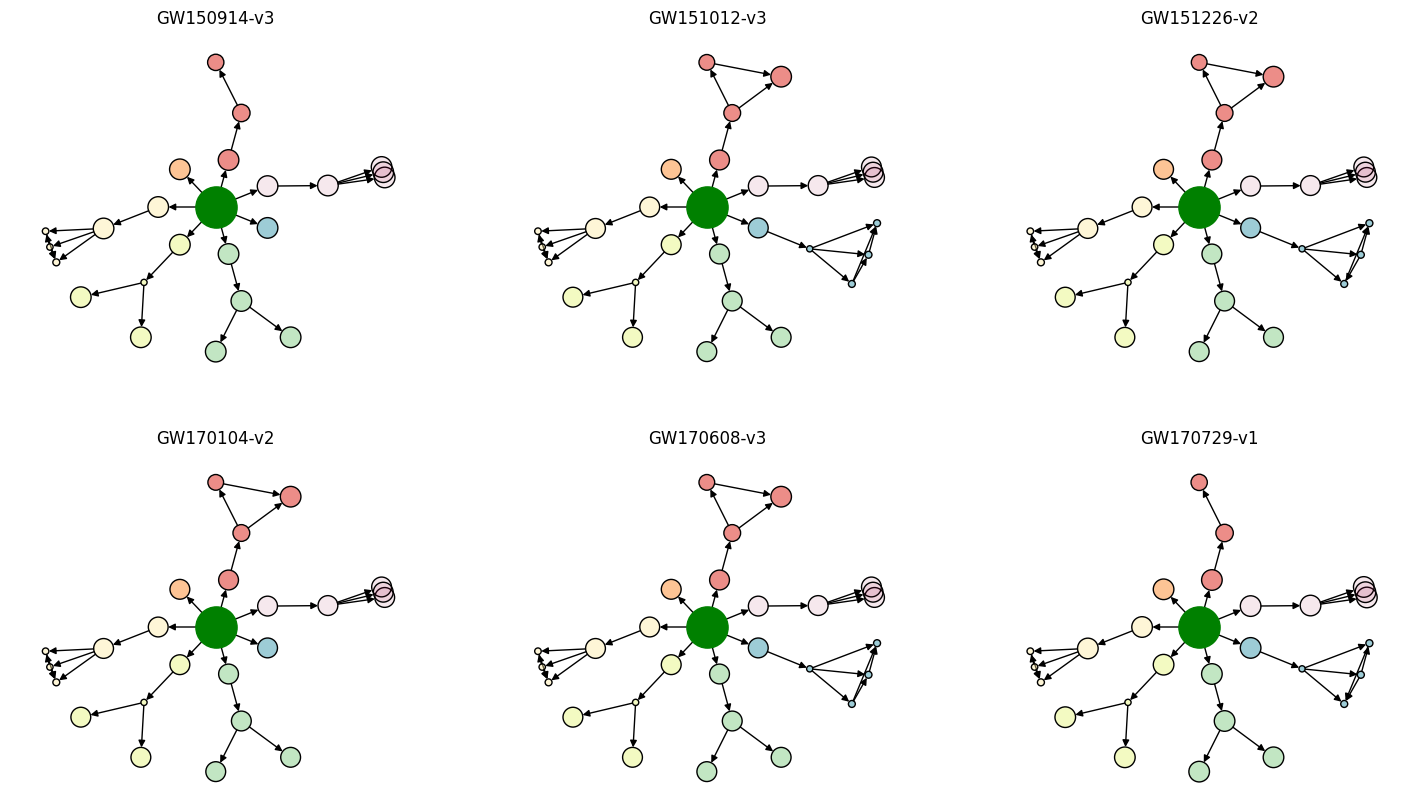

In [80]:
def run(filters, linkers, g, processed_df, alldf, hft, pipeline, n=6):
    pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
    rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    plt.savefig("rendered/untuned_{}.png".format(n))
    print("Average similarity of graphs tuned: {}".format(1 - np.mean(distances)))
    
run(filters, linkers, g, processed_df, alldf, hft, pipeline)

### Classification

In [81]:
def build_classification_data(processed_df, y, alldf, hft, pipeline):
    n = len(processed_df)

    start = time.time()
    rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
    t = time.time() - start
    print("Making rk models. Took {} seconds. {} seconds Per model".format(t, t/n))

    start = time.time()
    X = [ extract_rk_features(rk) for rk in rkmodels ]
    t = time.time() - start
    print("Extracted features. Took {} seconds. {} seconds Per model".format(t, t/n))
    return train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def classify1(X_train, X_test, y_train, y_test):
    
    encoder = LabelEncoder()
    y = encoder.fit_transform(y_train.str.strip())
    
    clf = OneVsRestClassifier(
        svm.SVC(kernel="linear", probability=True, random_state=1)
    )

    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)

    y_score = clf.decision_function(X_test)
    return clf, y_score

In [82]:
X_train, X_test, y_train, y_test = build_classification_data(processed_df, y, alldf, hft, pipeline)
clf, y_score = classify1(X_train, X_test, y_train, y_test)

Making rk models. Took 0.20215415954589844 seconds. 0.0022214742807241585 seconds Per model
Extracted features. Took 3.214308977127075 seconds. 0.0353220766717261 seconds Per model


Working on subset Neutron Star
Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) to default | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_low

/Users/akmb2/miniforge3/envs/gwpy-test/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/akmb2/miniforge3/envs/gwpy-test/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Average similarity Untuned + No Domain Expertise : 0.8244912652142952
Processed 5 rk models from 5
Average similarity Untuned + Domain Expertise: 0.8244912652142952
Processed 5 rk models from 5
Average similarity Tuned + Domain Expertise: 0.825804297922802
Working on subset Black Hole
Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to 

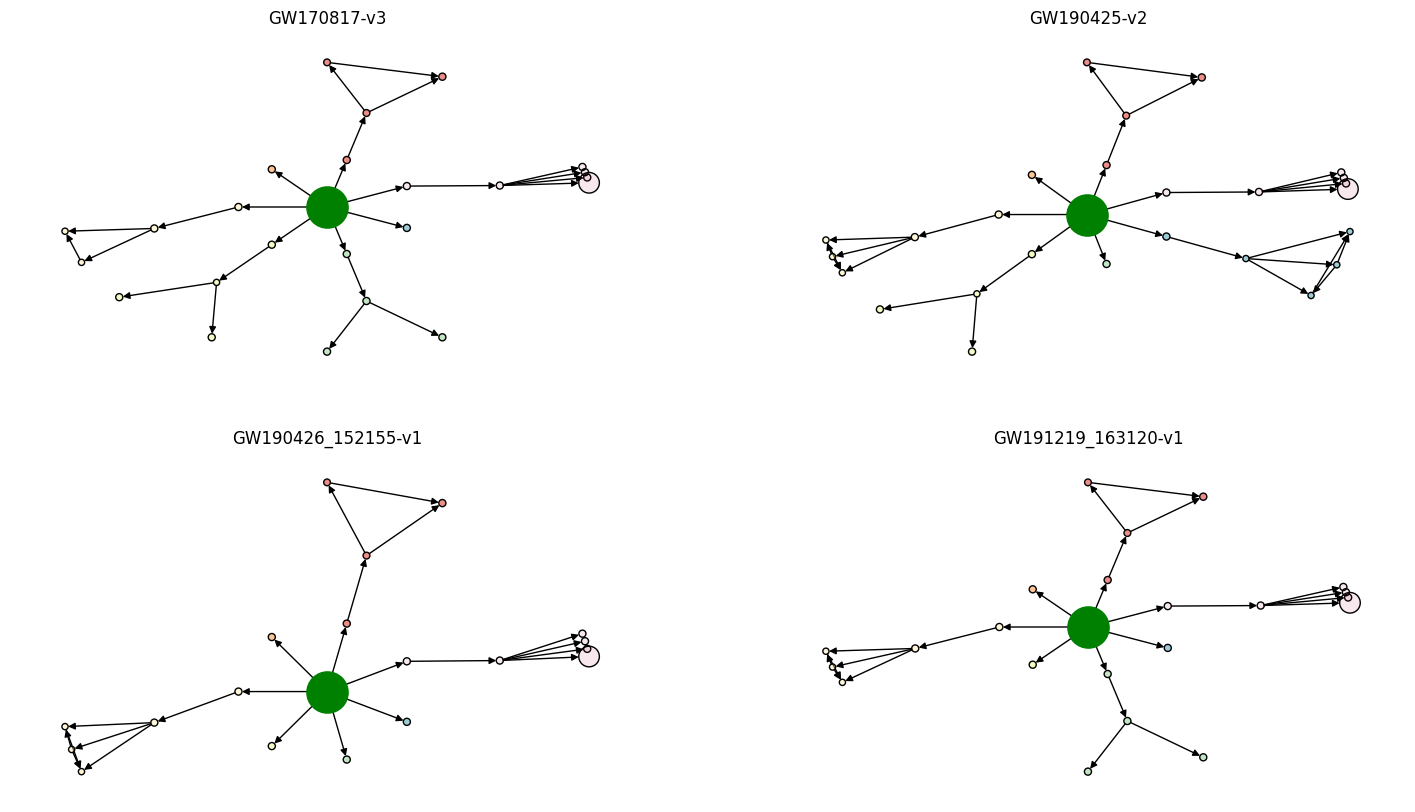

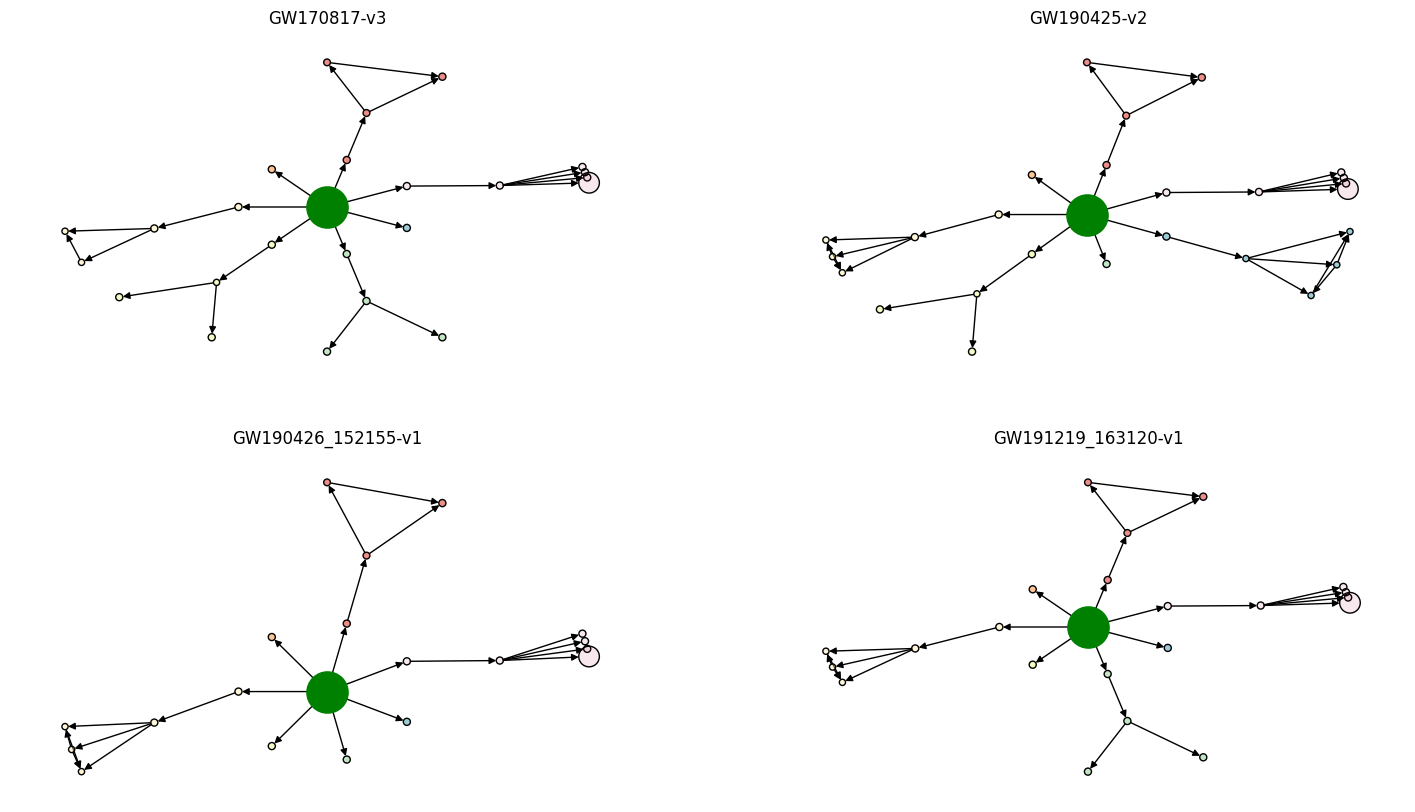

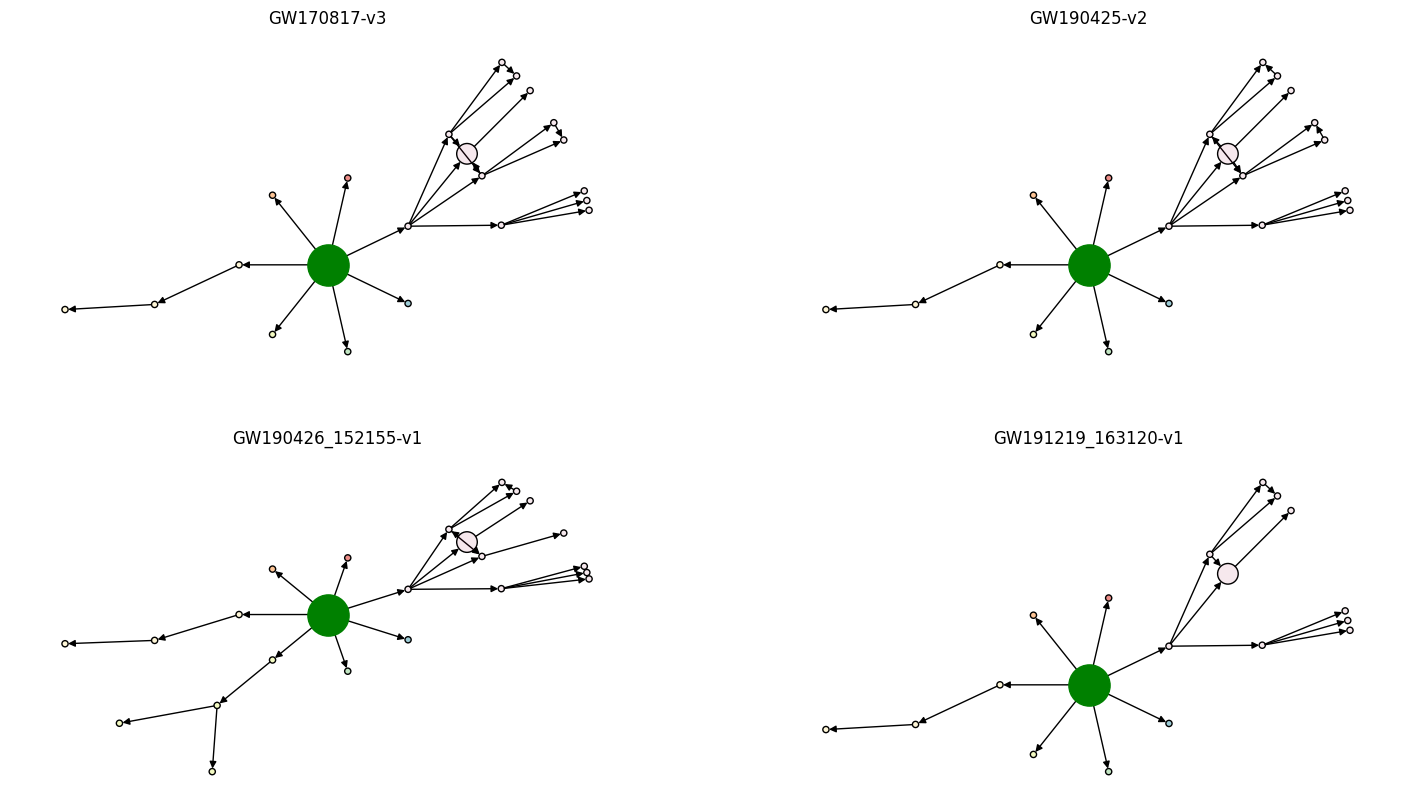

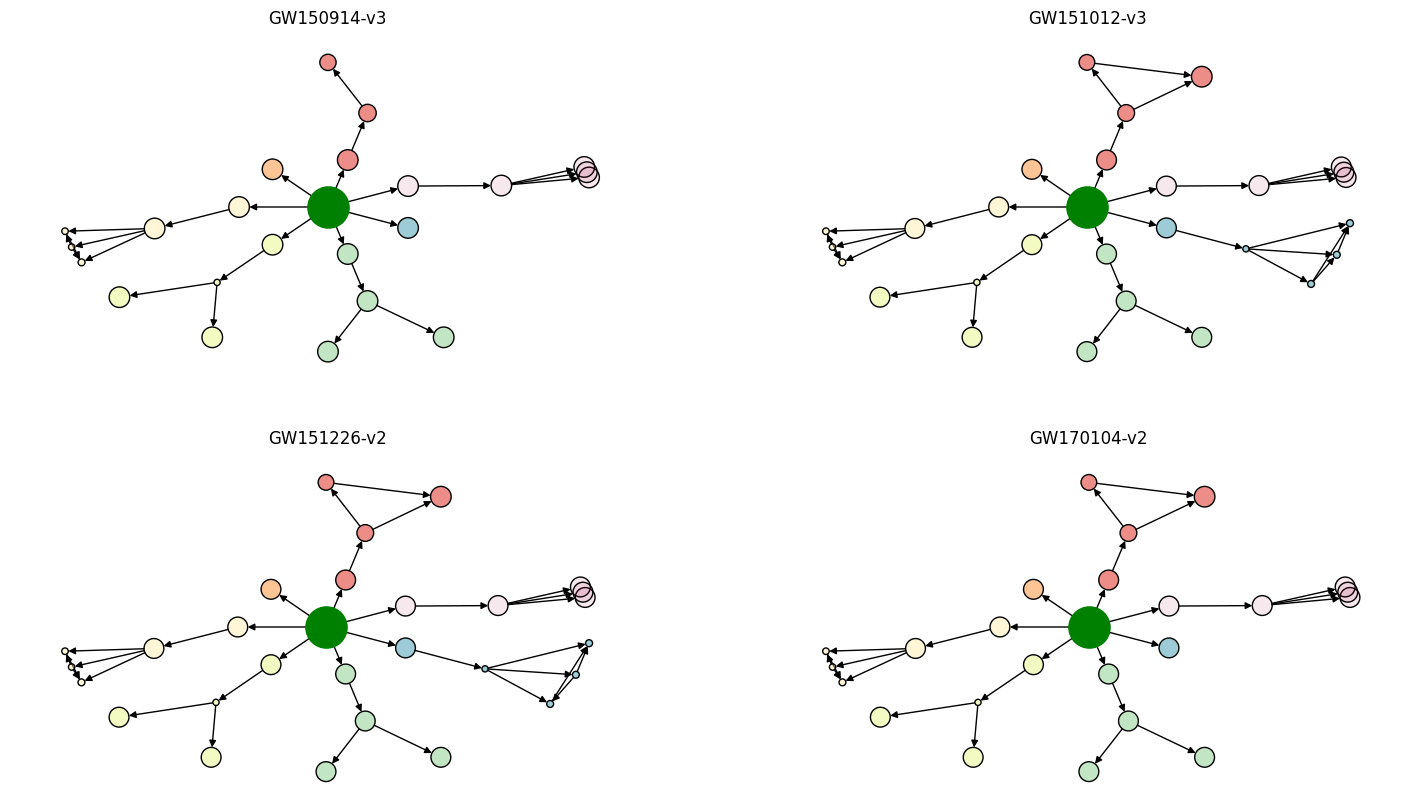

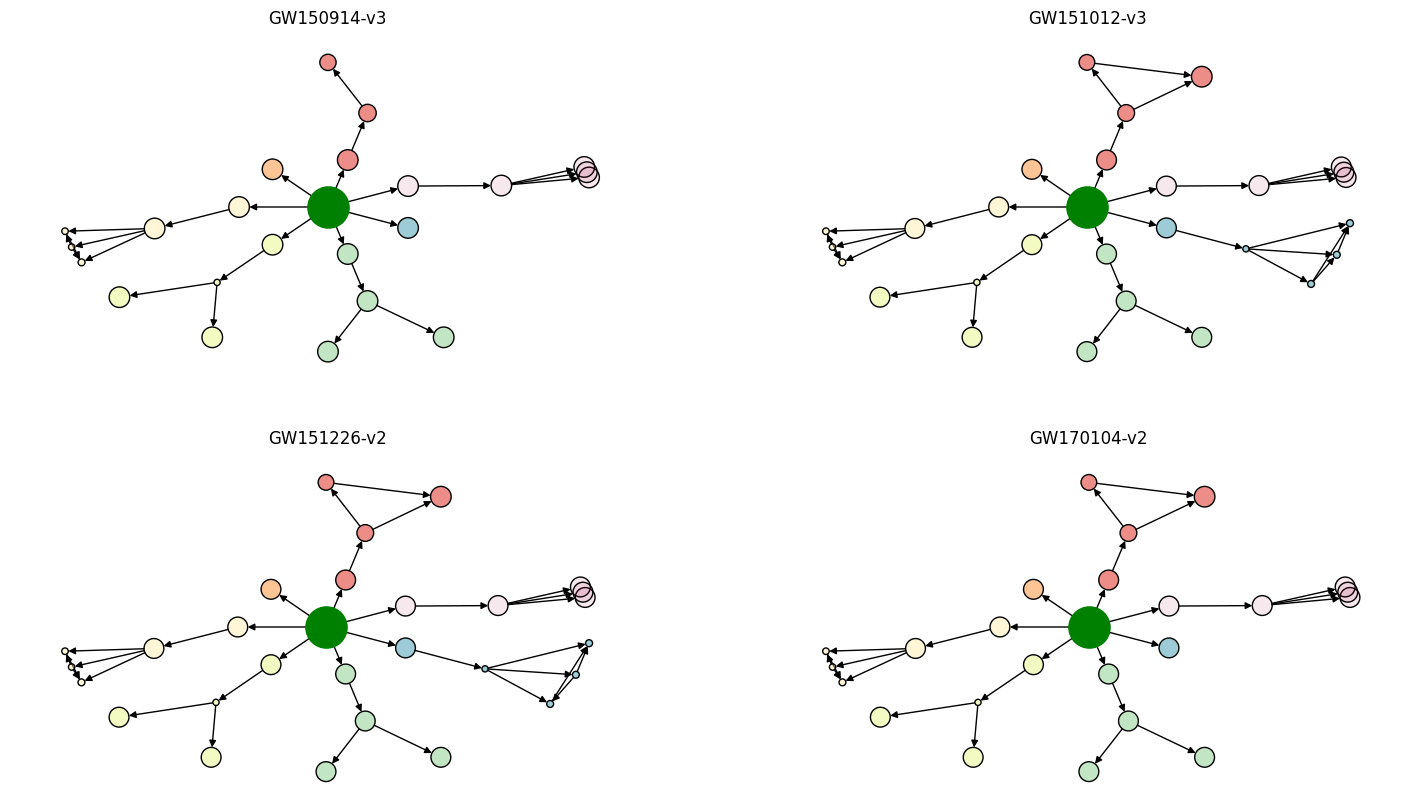

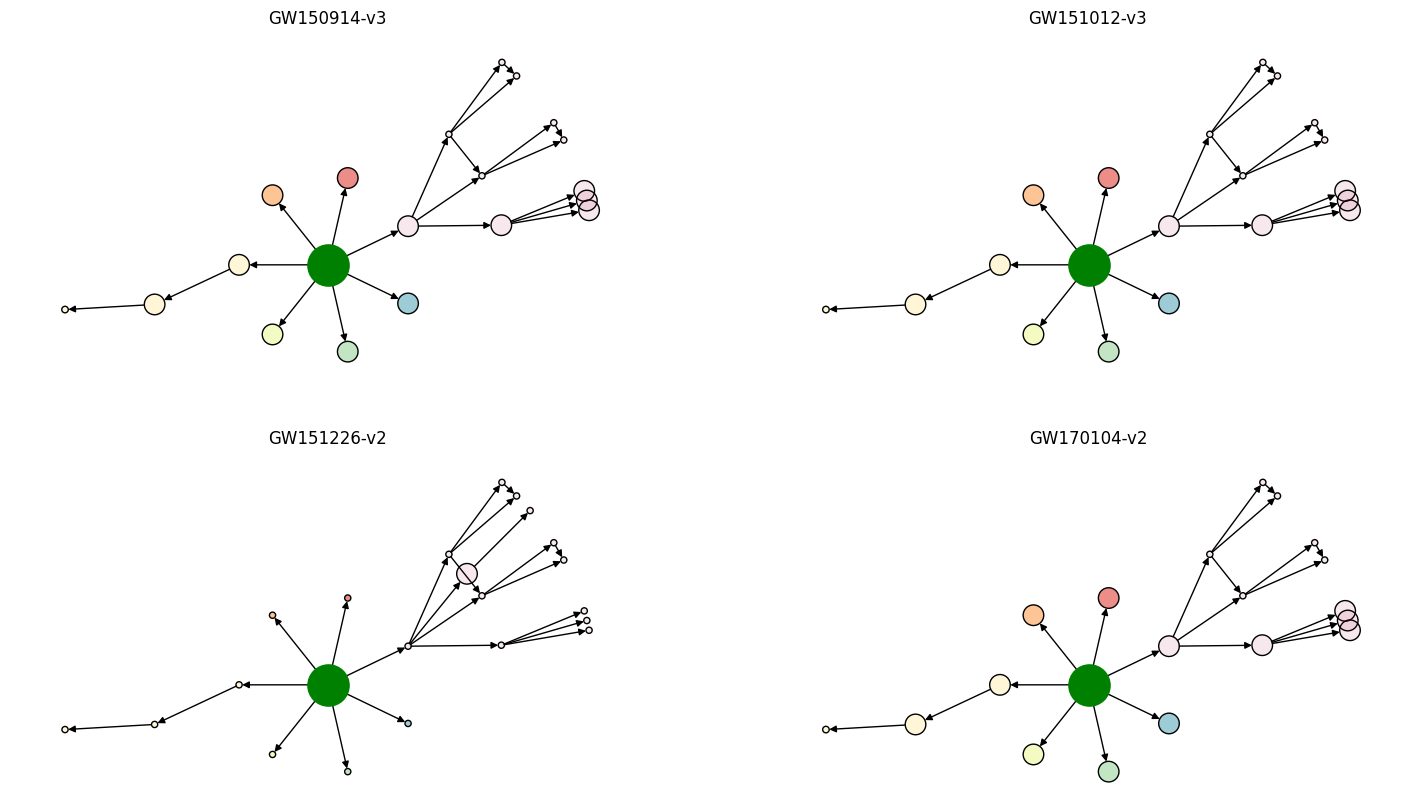

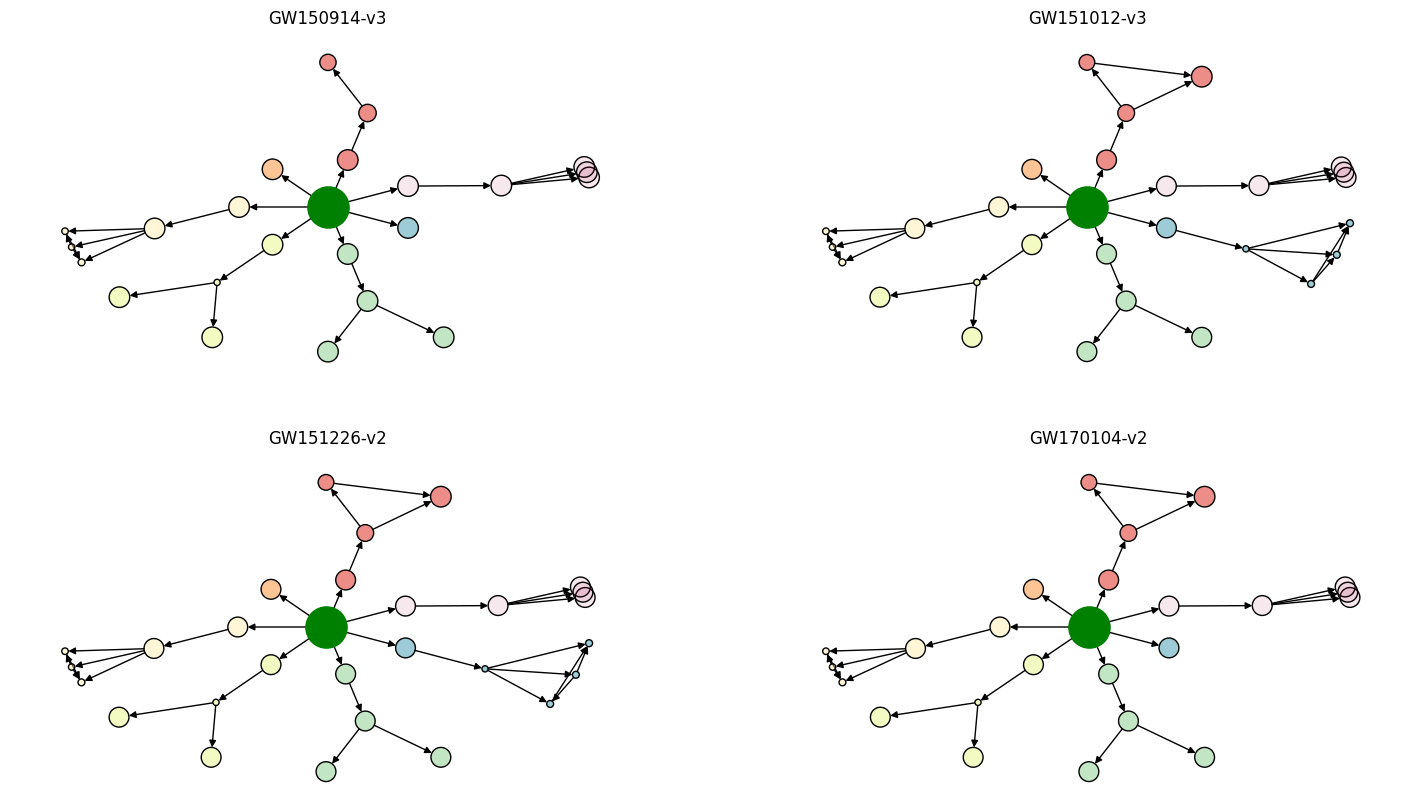

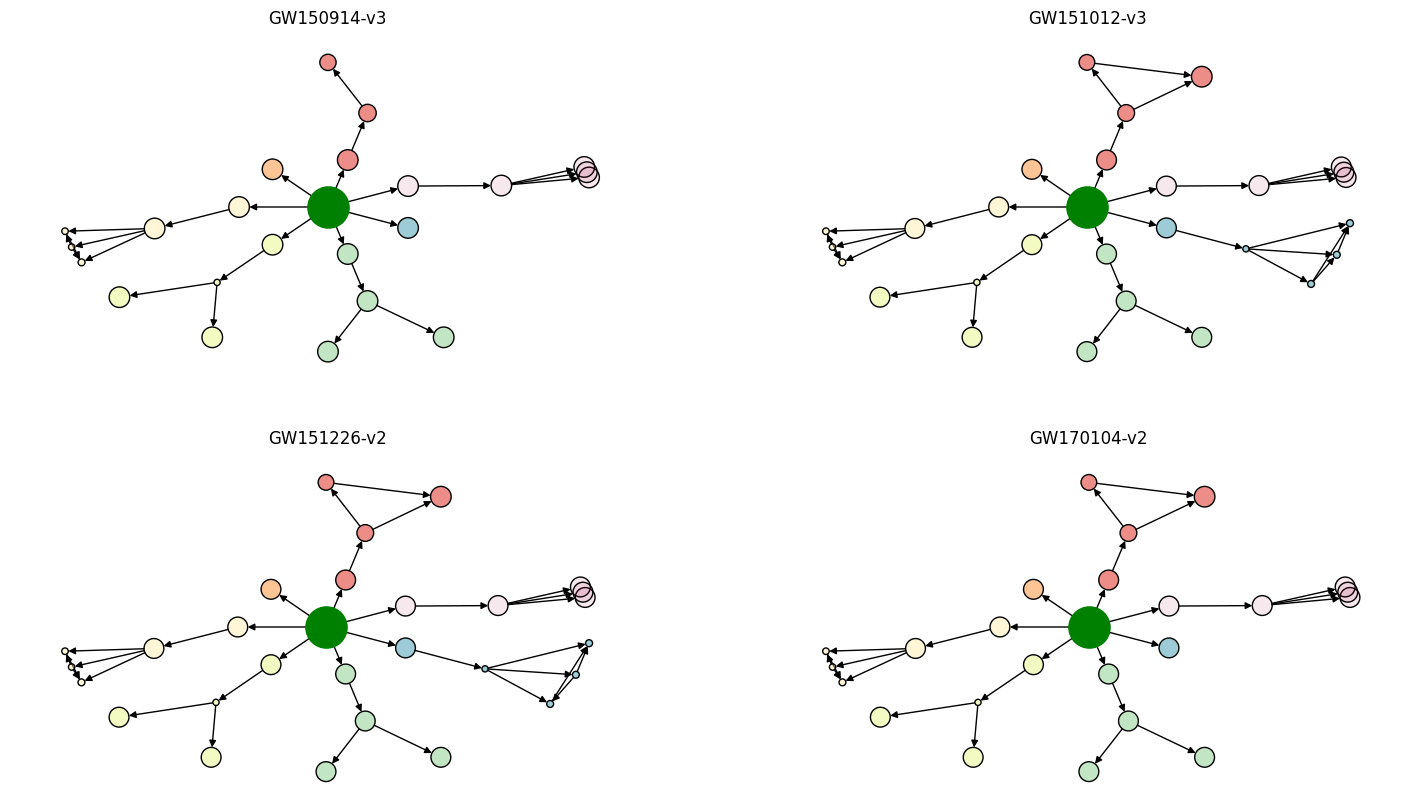

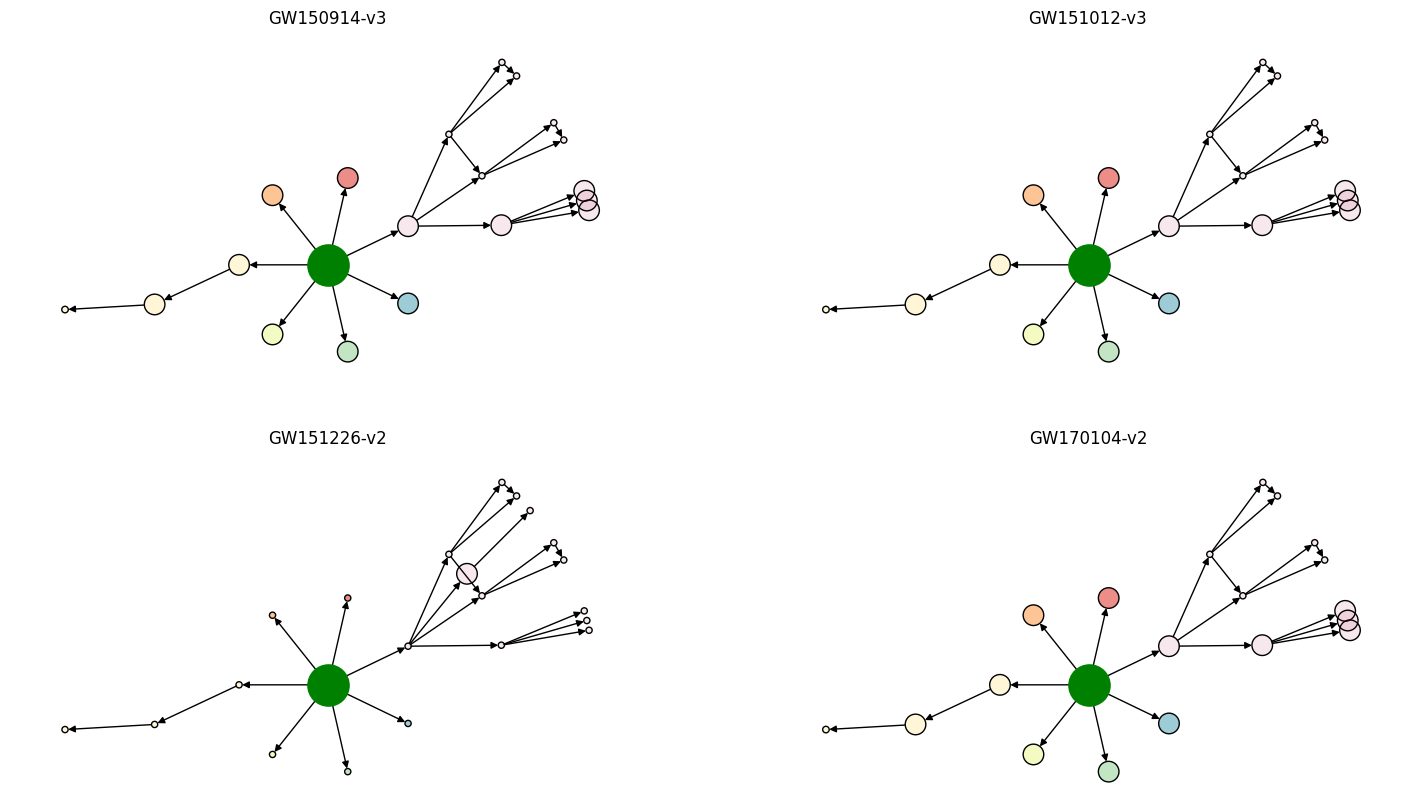

In [83]:
subsets = [ ("Neutron Star", filter_ns(df),y_train.str.contains("Neutron Star"), y_test.str.contains("Neutron Star")),
            ("Black Hole", filter_bh(df),y_train.str.contains("Black Hole"), y_test.str.contains("Black Hole")),
            ("All", [True] * len(df), [True] * len(y_train), [True] * len(y_test))]
#subsets = subsets[0]

def print_bold(s):
    print('\033[1m' + s + '\033[0m')
    
def show_models(pipeline, title, filename, processed_df, alldf, hft, n=4):
    subset_df = alldf
    rkmodels = make_n_rkmodels(processed_df, alldf,hft, pipeline, n=n, indexes=range(0,len(alldf)))
    print_bold("Processed {} rk models from {}".format(len(rkmodels), len(processed_df)))
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    #plt.savefig("rendered/untuned_{}_{}.png".format(filename, n))
    #plt.show()
    print_bold("Average similarity {}: {}".format(title, 1 - np.mean(distances)))
    
for s in subsets:
    print_bold("Working on subset " + s[0])
    pdf2 = processed_df[s[1]]
    df2 = df[s[1]]
    f, l = make_linkers_and_filters(g, {})
    untuned_pipeline = RKPipeline(filter_map=f, linkage_map=l, structural_graph=g)
    show_models(untuned_pipeline, "Untuned + No Domain Expertise ", s[0] + "_untuned_no_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )
    pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
    show_models(pipeline, "Untuned + Domain Expertise", s[0] + "_untuned_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )
    show_models(pipeline.remap(weights, w0[1]),  "Tuned + Domain Expertise", s[0] + "_tuned_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )


## Embedding

This is a quick and dirty way to embed an RK Diagram into space.

1. Get positions of TSNE embedding for the processed numerical data.
2. Impose in 2D space RK-Diagrams, giving ND representations into 2D space. 

In [86]:
import math 
from rktoolkit.visualizers.networkx.dendrogram import hierarchy_pos

    
def draw_rk_diagram2(rkmodel, ax=None, with_labels=True, minsize=100, center_color='green', spread=1,
                    alpha=300, emult=2, make_axis=False, width=2*math.pi, xoff=0, yoff=0, color_override=None):
    if make_axis:
        fig, ax = plt.subplots(figsize=(10,10))

    if ax is None:
        ax = plt.gca()
    
    # indexing
    nodes = list(rkmodel.G.nodes)
    g = rkmodel.get()
    node_subset = list(g.nodes)
    selected_indexes = [nodes.index(n) for n in node_subset]
    
    # positioning
    structural_pos = hierarchy_pos(rkmodel.G, 'root', width = width, xcenter=0)
    structural_pos = {u:(r*math.cos(theta)*spread,r*math.sin(theta)*spread) for u, (theta, r) in structural_pos.items()}
   
    # color 
    structural_colors = [ rkmodel.G.nodes[n].get('color','black') for n in nodes]
    filtered_colors = [structural_colors[i] for i in selected_indexes]
    if color_override is not None:
        if isinstance(color_override, str):
            filtered_colors = [color_override] * len(filtered_colors)

    # filter node to only ones that show after getting the rkm
    filtered_pos = {k: structural_pos[k] for k in node_subset}
    
    # update 
    for k,v in filtered_pos.items():
        filtered_pos[k] = [v[0]+xoff, v[1]+yoff]

    def _get_sizes(subset, defaultN=1, minsize=1):
        # convert all nodes into numeric values
        sizes = []
        for n in node_subset:
            v = rkmodel.G.nodes[n].get("value", 1)
            if not isinstance(v, numbers.Number):
                v = defaultN
            v+=minsize
            sizes.append(v)
        return sizes
    
    def _resize(sizes):
        sizes = np.array(sizes)
        sizes = sizes ** 5 #np.exp(sizes)
        sizes = (sizes - sizes.min()) / (sizes.max()-sizes.min())
        sizes *= alpha
        sizes += minsize
        sizes = np.where(np.isnan(sizes), minsize, sizes)
        return sizes

    sizes = _get_sizes(node_subset)
    sizes = _resize(sizes)
   
    nx.draw(g, pos=filtered_pos, with_labels=with_labels,
            font_size=10, node_size=sizes, ax=ax, node_color = filtered_colors, edgecolors = 'black')

    nx.draw_networkx_nodes(g, pos=filtered_pos, nodelist = ['root'],
                           node_color = center_color, ax=ax, node_size = sizes.max()*emult)


# TSNE

Note on TSNE. Change the `random_state` value to change the embedding.

360


/Users/akmb2/miniforge3/envs/gwpy-test/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/akmb2/miniforge3/envs/gwpy-test/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/var/folders/cw/fr7r0g091qz2q99rn0mr4_k40000gn/T/ipykernel_31499/778884337.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(np.array(np.arange(-10, 10, 2.7)),2), fontsize=8)
/var/folders/cw/fr7r0g091qz2q99rn0mr4_k40000gn/T/ipykernel_31499/778884337.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_

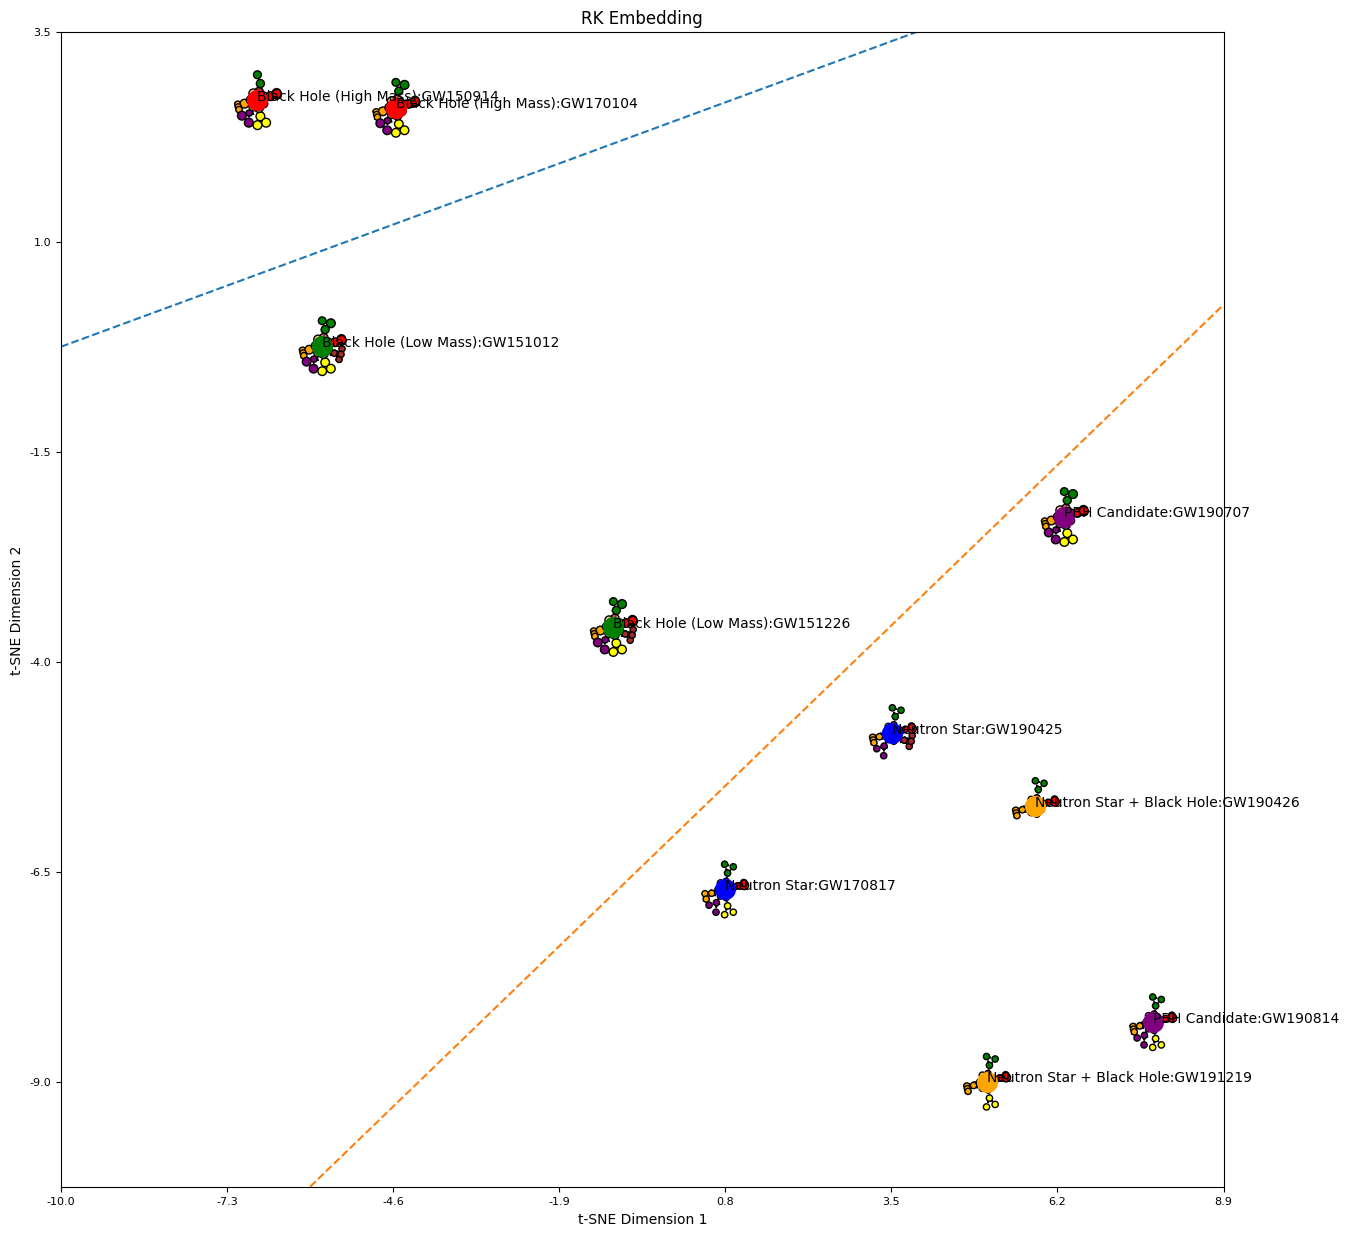

In [116]:
from sklearn import preprocessing
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FormatStrFormatter
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# create a list of subsets to view 
subset_x = []
for x in y.unique():
    subset_x.extend(np.where(y == x)[0][:2])

pre_embedded = processed_df.iloc[subset_x]
selected_labels = y[subset_x]

# change the Random state value here!

import random
random_seed = random.randint(1, 600)
print(random_seed)
random_seed = 163
X_embedded = TSNE(n_components=2, init='random',random_state=random_seed, perplexity=5).fit_transform(processed_df.astype(np.float64))
X_embedded = MinMaxScaler().fit_transform(X_embedded)

def embed_rkdiagrams(subset_idxs, embedded_data, df, y, spread=100):
    
    placements = []
    fig, ax = plt.subplots(figsize=(15,15))
    le = preprocessing.LabelEncoder().fit_transform(y)
    colors = ["red", "green", "blue", "orange", 'purple', 'yellow', 'brown']
    children = pipeline.structural_graph.get_children('root')

    for i, idx in enumerate(subset_idxs): 
        
        pos = embedded_data[i]
        data = processed_df.iloc[idx]
        name = df['commonName (Event Name)'].iloc[idx].split("_")[0]
        label = selected_labels.iloc[i]

        base = hft.transform(data)
        rkm = pipeline.transform(base, is_base=False)
        for i, c in enumerate(children):
            for _, cn in enumerate(rkm.G.get_children(c, recursive=True)):
                 rkm.G.nodes[cn]['color'] = colors[i]
                    
        draw_rk_diagram2(rkm, ax=ax, with_labels=False,
                         spread=2, 
                         center_color=colors[le[idx]],
                         xoff=pos[0]*spread, 
                         yoff=pos[1]*spread, 
                         minsize=20, alpha=20, 
                         emult=5, make_axis=False)  
    
        ax.text(pos[0]*spread, pos[1]*spread, "{}:{}".format(label, name))
        placements.append(pos * spread)
    
    # directly place lines for visuals. 
    # this was requested for demonstration purposes.
    # line was manually determined.
    l1 = np.array([[210, 35],[265, 51]])
    plt.plot(l1[:,0], l1[:,1], '--'	) # these were chosen manually for demonstration purposes!
  
    l1 = np.array([[225,-5],[280, 37]])
    plt.plot(l1[:,0], l1[:,1], '--'	)
    
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    limits=plt.axis('on') # turns on axis

    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.set_xlim([210, 280])
    ax.set_ylim([-5, 50])

    np.set_printoptions(precision=2)
    ax.set_xticklabels(np.round(np.array(np.arange(-10, 10, 2.7)),2), fontsize=8)
    ax.set_yticklabels(np.round(np.array(np.arange(-11.5, 10, 2.5)),2), fontsize=8)

    plt.title("RK Embedding")
    plt.show()
    
embed_rkdiagrams(subset_x, X_embedded, df, y, spread=500 )

### Interclass Similarity Scores

Initial method is pretty primative.

1. Subset data in the class
2. Take the averages of each subset
3. Convert that to an RK Model as the "class" model
4. Find the distances X classes

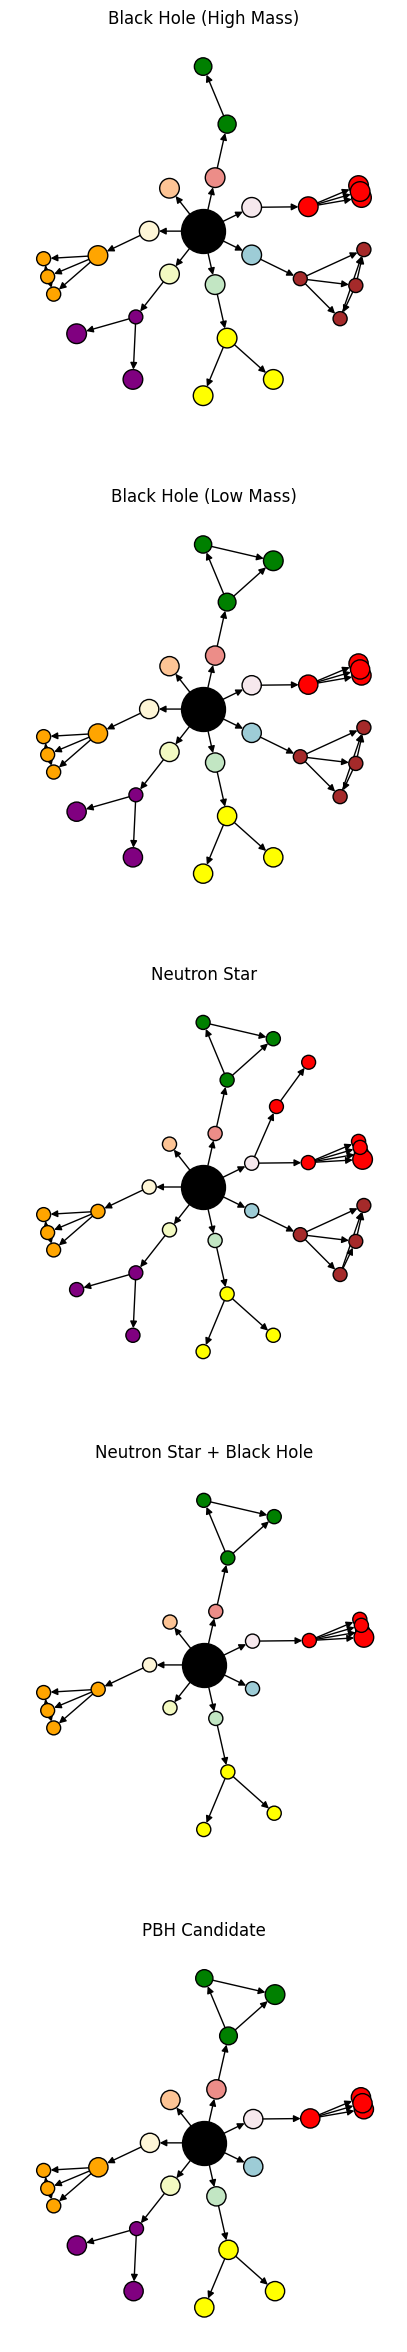

In [18]:
average_graph = {}

for c in alldf.Classification.unique():
    average_graph[c] = np.median(processed_df[alldf.Classification == c], axis=0)
    
fig, axes = plt.subplots(5,1, figsize=(5,30))

i = 0

average_rk = {}
import math
colors = ["red", "green", "blue", "orange", 'purple', 'yellow', 'brown']
le = preprocessing.LabelEncoder().fit_transform(y)

for name, data in average_graph.items():
    a,b = i%2, math.floor(i/2)
    ax = axes[i]
    data = pd.DataFrame(data)
    data.index = processed_df.columns
    data = data.T
    data = data.iloc[0]
    base = hft.transform(data)
    rkm = pipeline.transform(base, is_base=False)
    
    average_rk[name] = rkm
    spread = 1
    draw_rk_diagram2(rkm, ax=ax, with_labels=False,
                     spread=1, 
                     center_color='black',
                     xoff=0, 
                     yoff=0, 
                     minsize=100, alpha=100, 
                     emult=5, make_axis=False) 
    
    i+=1
    ax.set_title(name)
plt.show()

In [19]:
import itertools
from rktoolkit.functions.distance import mahalanobis, jaccard
import scipy.spatial.distance as distance
dist = []
for a, b in itertools.combinations(average_rk, 2):
    ag, bg = average_rk[a].get(), average_rk[b].get()
    vdist = distance.cosine(average_graph[a], average_graph[b])
    edist = jaccard(ag.nodes, bg.nodes)
    #edist = ag.edge_distance(bg)
    dist.append([a,b, edist, vdist, (vdist+edist)/2, 1-((vdist+edist)/2)])
    
pd.DataFrame(dist, columns=["Class 1", "Class 2", "Topological Distance", "Value Distance", "Average Distance", "Average Similarity"])

Class 1                    Class 2  Topological Distance  \
0     Black Hole (High Mass)      Black Hole (Low Mass)              0.034483   
1     Black Hole (High Mass)               Neutron Star              0.125000   
2     Black Hole (High Mass)  Neutron Star + Black Hole              0.300000   
3     Black Hole (High Mass)              PBH Candidate              0.172414   
4      Black Hole (Low Mass)               Neutron Star              0.093750   
5      Black Hole (Low Mass)  Neutron Star + Black Hole              0.266667   
6      Black Hole (Low Mass)              PBH Candidate              0.137931   
7               Neutron Star  Neutron Star + Black Hole              0.281250   
8               Neutron Star              PBH Candidate              0.218750   
9  Neutron Star + Black Hole              PBH Candidate              0.153846   

   Value Distance  Average Distance  Average Similarity  
0    1.432188e-12          0.017241            0.982759  
1    3.149037e-12          0.062500            0.937500  
2    2.543632e-12          0.150000            0.850000  
3    2.025491e-12          0.086207            0.913793  
4    3.500533e-13          0.046875            0.953125  
5    1.689759e-13          0.133333            0.866667  
6    5.484502e-14          0.068966            0.931034  
7    3.297362e-14          0.140625            0.859375  
8    1.281197e-13          0.109375            0.890625  
9    3.175238e-14          0.076923            0.923077

In [2]:
df = make_df_from_sheet(r"data/GWTC_2021_Master.csv") # read the file
df.head(n=1)

id (Event ID) commonName (Event Name)          Classification  version  \
0   GW150914-v3                GW150914  Black Hole (High Mass)        3   

  catalog.shortName         GPS  Mass_1_source (solar masses)  \
0  GWTC-1-confident  1126259462                          35.6   

   mass_1_source_upper_error  Mass_1_Upper Limit (solar masses)  \
0                        4.7                               40.3   

   mass_1_source_lower_error  ...  redshift_upper_limit           far  \
0                       -3.1  ...                  0.12  1.000000e-07   

   far_lower  far_upper  p_astro  p_astro_lower  p_astro_upper  \
0        NaN        NaN      1.0            NaN            NaN   

   final_mass_source  final_mass_source_lower  final_mass_source_upper  
0               63.1                     -3.0                      3.4  

[1 rows x 53 columns]

In [3]:
def filter_bh(df): 
    # returns indexes of bh items
    return df.Classification.str.contains("Black Hole")

def filter_ns(df):
    return df.Classification.str.contains("Neutron Star")

# Load the hierarchy

Change the hierarchy file here to change the ontology

/Users/akmb2/miniforge3/envs/gwpy-test/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


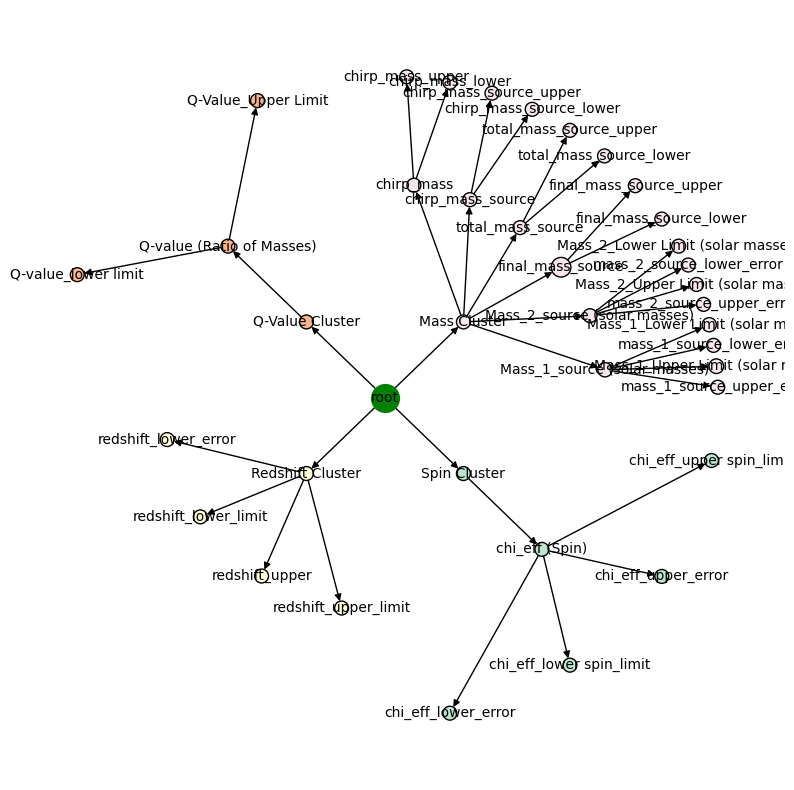

In [26]:
# load the heirarchy file.
from rktoolkit.functions.htg_transformers import BaseOntologyTransform
from rktoolkit.visualizers.util import draw_graph

# hierarchy_file = r'data/gwtc_heirarchy_pretty.json'
# uncommment the below line for other file 
hierarchy_file = r'data/new_heirarchy_for_rk_similarity.json'

hft = BaseOntologyTransform(mapping=json.load(open(hierarchy_file, "r")))
processed_df, y, alldf, ids = preprocess(df)

# plot the heirarchy
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
g = hft.transform(processed_df.iloc[0])
draw_graph(g , ax=ax, with_labels=True, minsize=100, alpha=100, emult=2, make_axis=False) 
os.makedirs("rendered", exist_ok=True)
plt.savefig("rendered/heirarchy_graph.png")

In [27]:
opts = {
    "chi_eff (Spin)": [-0.1, 0.1],
    "Q-value (Ratio of Masses)": [.01, .88]
}
import numbers
from rktoolkit.functions.filters import RangeFilter
from rktoolkit.functions.linkers import SimpleChildLinker

def make_linkers_and_filters(graph, opts={}):
    '''
    Defaults all filters to be a range filter. And the linker to be a simple child linker. 
    '''
    ENDL = " | " 
    filters, linkers = {}, {}
    for k, v in graph.nodes.items():
        if 'value' in v and isinstance(v['value'], numbers.Number):
            if v["id"] in opts:
                print("Set {:s} from options".format(v["id"]), end=ENDL)
            else:
                print("Set {:s} to default".format(v["id"]), end=ENDL)
            minv, maxv = opts.get(v["id"][0], 0), opts.get(v["id"][1], 1)
            filters[k] = RangeFilter(min=minv, max=maxv)        
    linkers['root'] = SimpleChildLinker()
    return filters, linkers

filters, linkers = make_linkers_and_filters(g, opts)

Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) from options | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set redshift_lower_error to default | Set redshift_lower_limit to default | Set redshift_upper to default | Set redshift_upper_limit to default | Set chi_eff

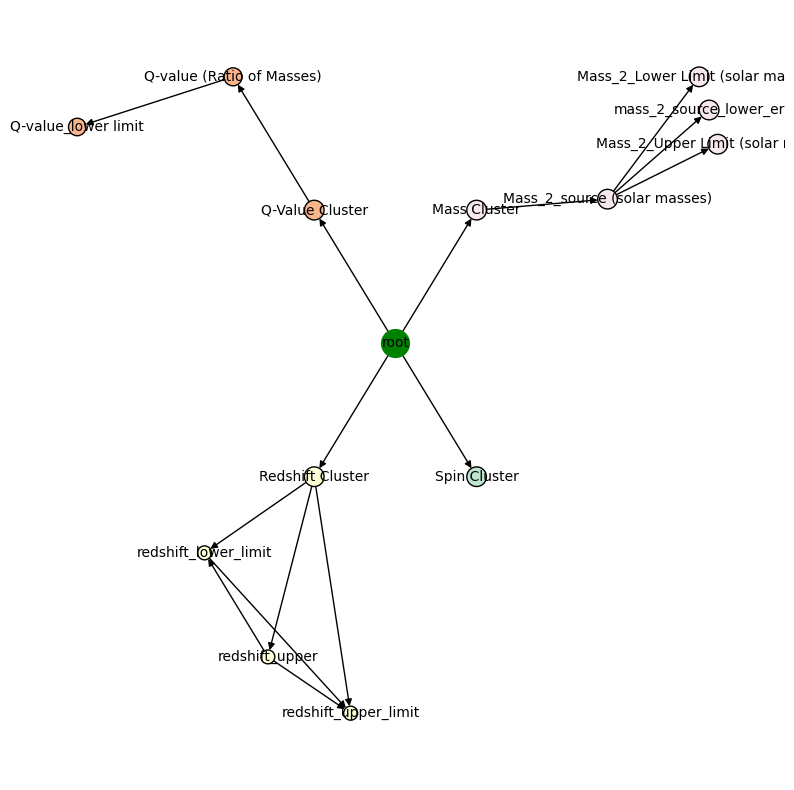

In [28]:
from rktoolkit.models.pipeline import RKPipeline 
from rktoolkit.visualizers.util import draw_rk_diagram
from rktoolkit.models.graph import Edge 

pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
g2 = pipeline.transform(g, is_base=False)
fig, ax = plt.subplots(figsize=(10,10))
draw_rk_diagram(g2, ax=ax, with_labels=True, minsize=100, alpha=100, emult=2, make_axis=False)  
plt.savefig("rendered/rk_graph1.png")

## Untuned Visualizations

Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) to default | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set redshift_lower_error to default | Set redshift_lower_limit to default | Set redshift_upper to default | Set redshift_upper_limit to default | Set chi_eff (

/Users/akmb2/miniforge3/envs/gwpy-test/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Average similarity of graphs pre tuned: 0.9117155400601717


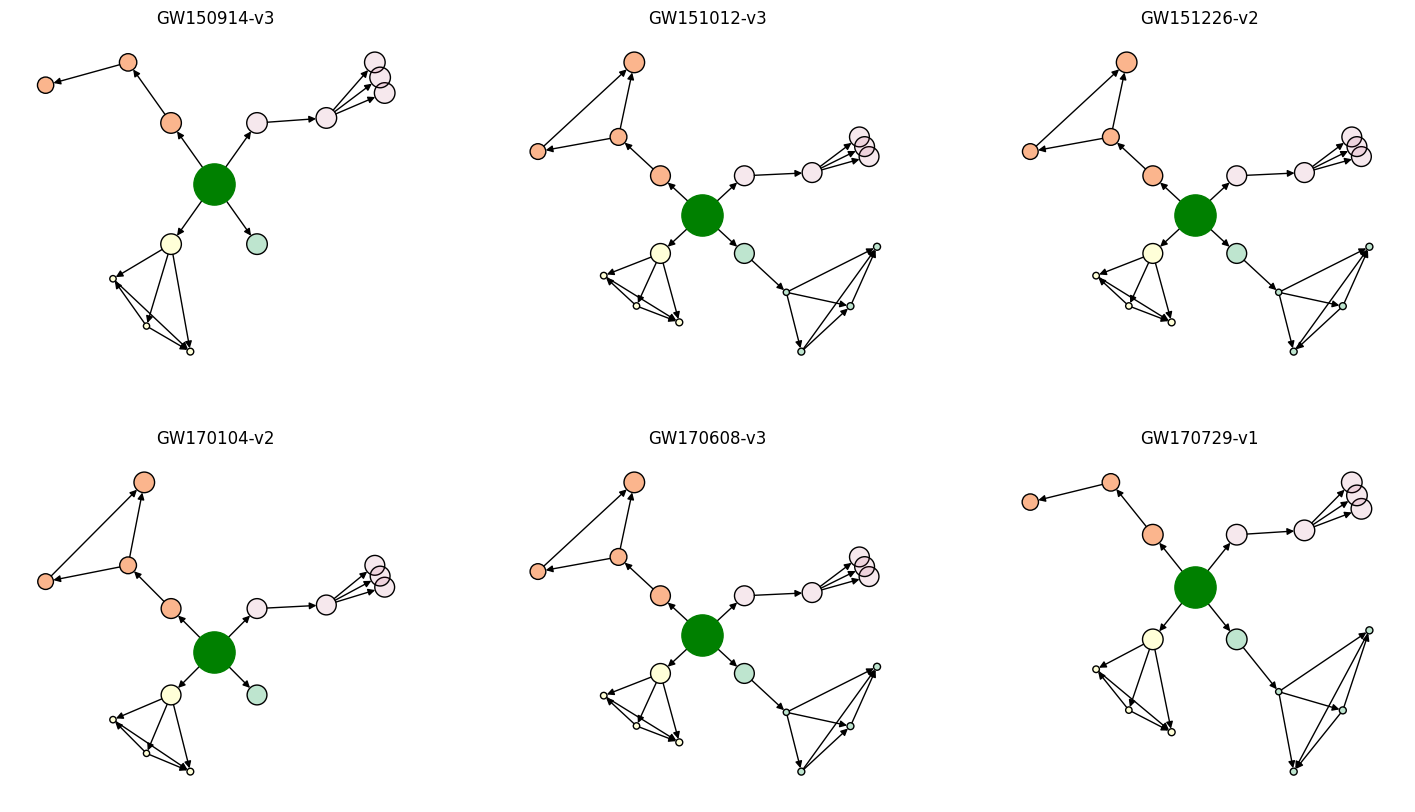

In [29]:
# completely untuned
f, l = make_linkers_and_filters(g, {})
n = 6
pipeline = RKPipeline(filter_map=f, linkage_map=l, structural_graph=g)
rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
mdist = compute_distance(processed_df)
distances = compute_distances(rkmodels, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

Average similarity of graphs pre tuned: 0.9117155400601717


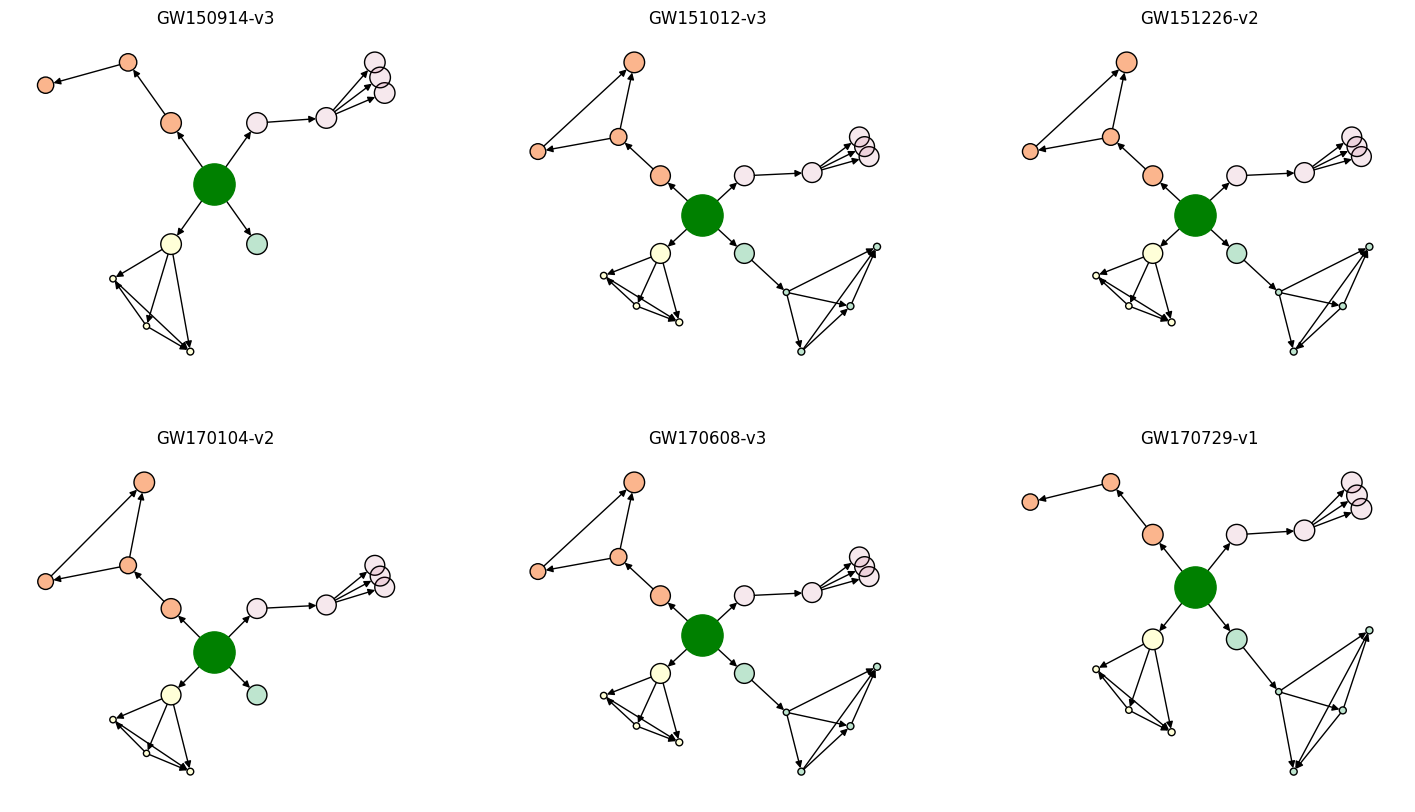

In [30]:
n = 6
pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
mdist = compute_distance(processed_df)
distances = compute_distances(rkmodels, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

In [31]:
selected_events = ["GW170729", "GW170817", "GW190814", "GW190521"]
subset_df = df[df["commonName (Event Name)"].isin(selected_events)]
label_df = df.iloc[subset_df.index]

def build_4_model(pipeline, title, filename):
    n = 4
    rkmodels = make_n_rkmodels(processed_df, alldf,hft, pipeline, n=n, indexes=list(subset_df.index))
    print("Processed {} rk models from {}".format(len(rkmodels), len(processed_df)))
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    
    plt.savefig("rendered/untuned_{}_{}.png".format(filename, n))
    plt.show()
    print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

## Tuning

Iteration: 00100. Loss: 0.85740618. ITime 5.70 seconds. Total time: 5.79
Iteration: 00200. Loss: 0.91420709. ITime 6.06 seconds. Total time: 11.86
Iteration: 00300. Loss: 0.89519885. ITime 5.94 seconds. Total time: 17.80
Iteration: 00400. Loss: 0.91120743. ITime 5.87 seconds. Total time: 23.68
Iteration: 00500. Loss: 0.83645466. ITime 6.00 seconds. Total time: 29.68
Iteration: 00600. Loss: 0.89641687. ITime 5.82 seconds. Total time: 35.50
Iteration: 00700. Loss: 0.86647131. ITime 5.97 seconds. Total time: 41.47
Iteration: 00800. Loss: 0.89145299. ITime 6.46 seconds. Total time: 47.94
Iteration: 00900. Loss: 0.87811847. ITime 6.04 seconds. Total time: 53.98
Iteration: 01000. Loss: 0.93536020. ITime 5.86 seconds. Total time: 59.84
Iteration: 01100. Loss: 0.88478632. ITime 5.78 seconds. Total time: 65.62
Iteration: 01200. Loss: 0.87711428. ITime 5.85 seconds. Total time: 71.47
Iteration: 01300. Loss: 0.83582603. ITime 5.72 seconds. Total time: 77.20
Iteration: 01400. Loss: 0.83691508. ITi

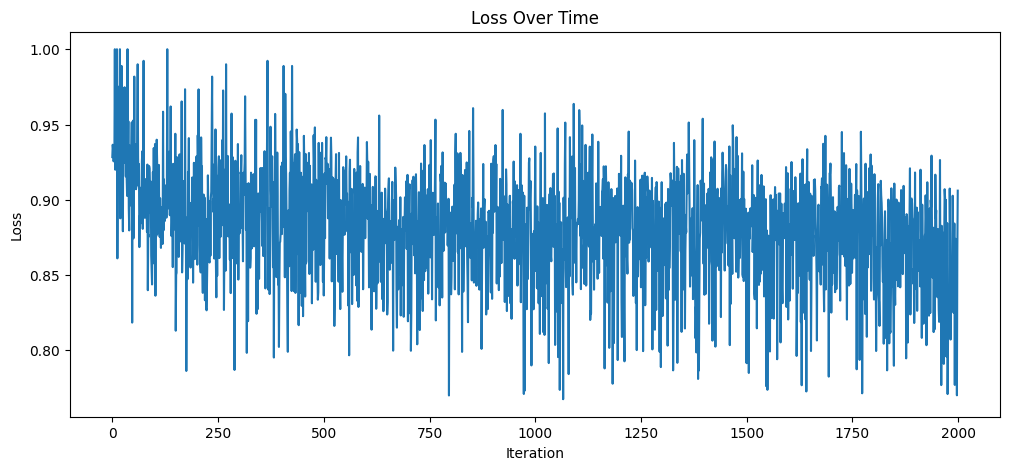

<Figure size 640x480 with 0 Axes>

In [32]:
w0 = pipeline.get_w()
weights, history = train(len(w0[0]), pipeline, processed_df, hft, mdist)
show(weights, history, pipeline, processed_df, hft, w0)

### Saving Weights and Loading Weights

In [45]:
def save_weights(weights, directory="weights", filename="weights2"):
    # overrides the weights file
    directory = "weights"
    if not os.path.exists(directory):
        os.makedirs(directory)
    np.savetxt('{}/{}.txt'.format(directory,filename), weights)

def load_weights(path):
    return np.loadtxt(path)

save_weights(weights)
weights = load_weights("weights/weights2.txt")

Average similarity of graphs tuned: 0.9117155400601717


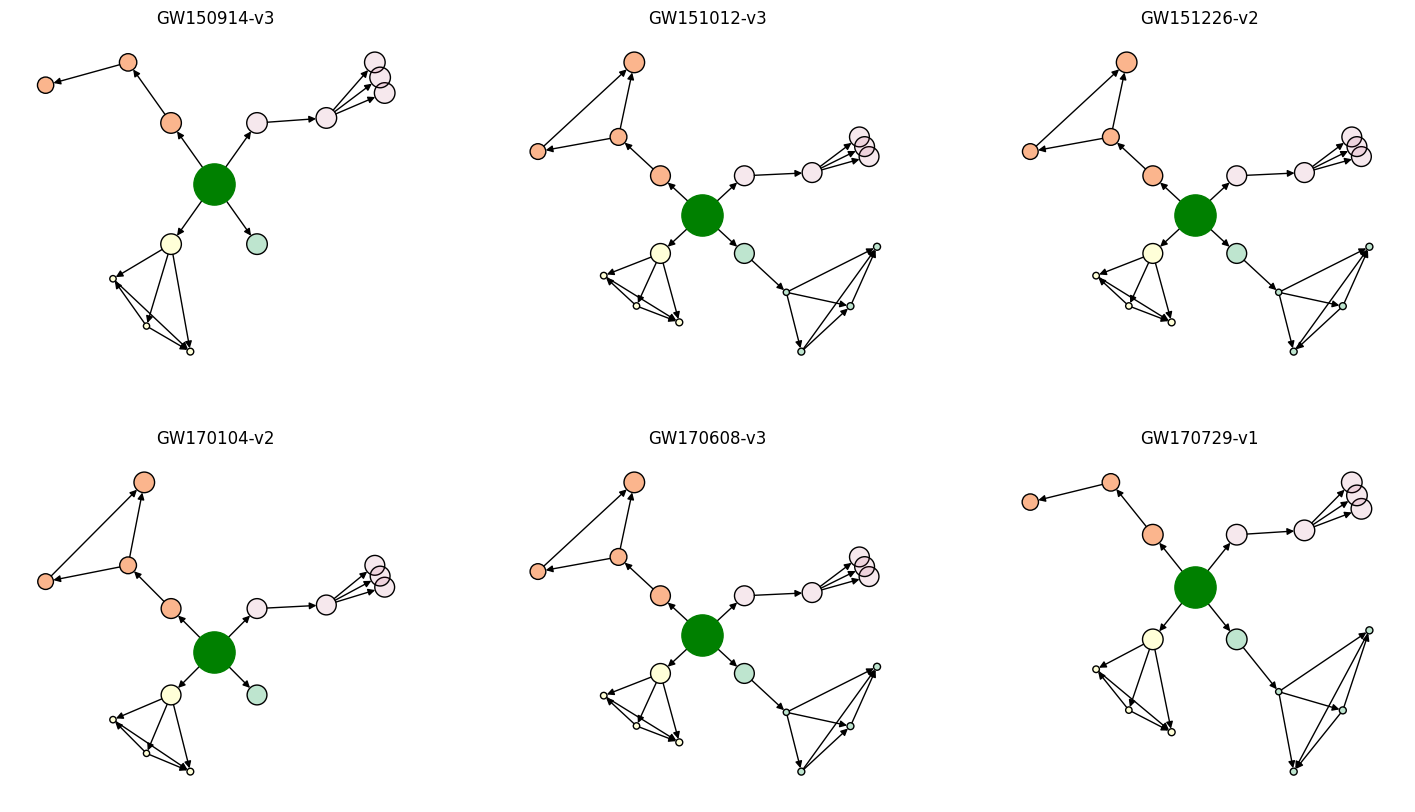

In [38]:
def run(filters, linkers, g, processed_df, alldf, hft, pipeline, n=6):
    pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
    rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    plt.savefig("rendered/untuned_{}.png".format(n))
    print("Average similarity of graphs tuned: {}".format(1 - np.mean(distances)))
    
run(filters, linkers, g, processed_df, alldf, hft, pipeline)

### Classification

In [39]:
def build_classification_data(processed_df, y, alldf, hft, pipeline):
    n = len(processed_df)

    start = time.time()
    rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
    t = time.time() - start
    print("Making rk models. Took {} seconds. {} seconds Per model".format(t, t/n))

    start = time.time()
    X = [ extract_rk_features(rk) for rk in rkmodels ]
    t = time.time() - start
    print("Extracted features. Took {} seconds. {} seconds Per model".format(t, t/n))
    return train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def classify1(X_train, X_test, y_train, y_test):
    
    encoder = LabelEncoder()
    y = encoder.fit_transform(y_train.str.strip())
    
    clf = OneVsRestClassifier(
        svm.SVC(kernel="linear", probability=True, random_state=1)
    )

    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)

    y_score = clf.decision_function(X_test)
    return clf, y_score

In [40]:
X_train, X_test, y_train, y_test = build_classification_data(processed_df, y, alldf, hft, pipeline)
clf, y_score = classify1(X_train, X_test, y_train, y_test)

Making rk models. Took 0.2140653133392334 seconds. 0.0023523660806509163 seconds Per model
Extracted features. Took 0.9837589263916016 seconds. 0.010810537652654962 seconds Per model


Working on subset Neutron Star
Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) to default | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set redshift_lower_error to default | Set redshift_lower_limit to default | Set redshift_upper to default | Set redshift_upper_l

/Users/akmb2/miniforge3/envs/gwpy-test/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/akmb2/miniforge3/envs/gwpy-test/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Average similarity Untuned + No Domain Expertise : 0.8387641974182618
Processed 5 rk models from 5
Average similarity Untuned + Domain Expertise: 0.8387641974182618


IndexError: list index out of range

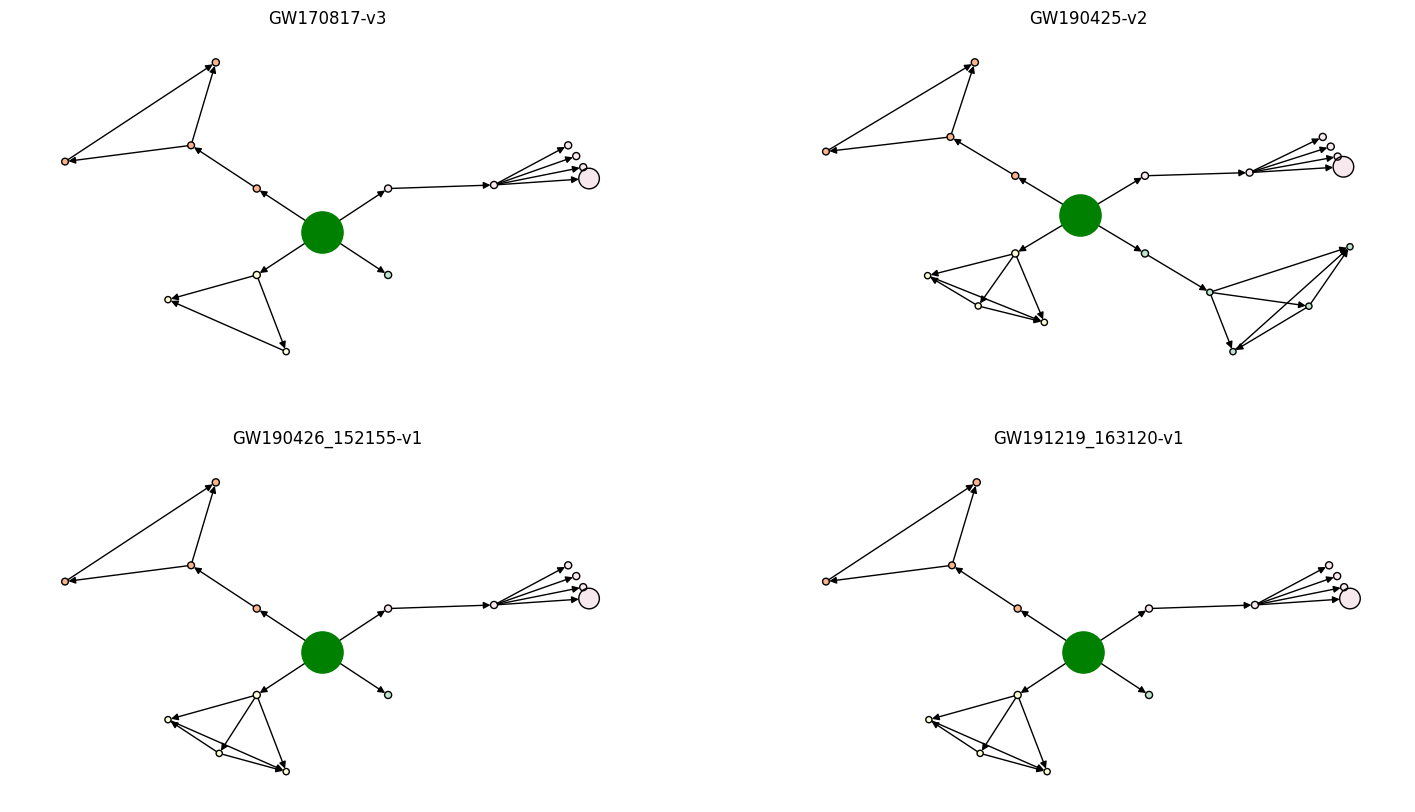

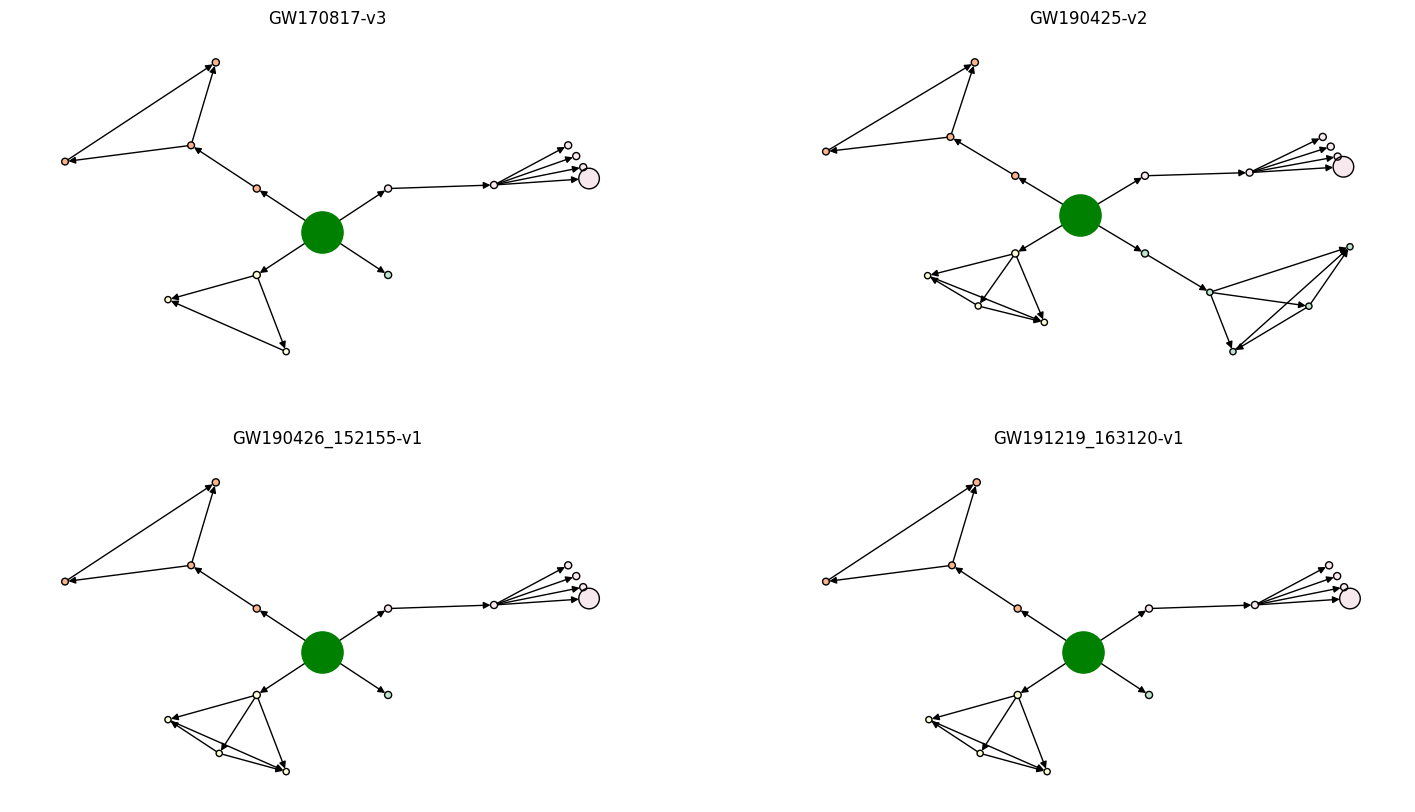

In [41]:
subsets = [ ("Neutron Star", filter_ns(df),y_train.str.contains("Neutron Star"), y_test.str.contains("Neutron Star")),
            ("Black Hole", filter_bh(df),y_train.str.contains("Black Hole"), y_test.str.contains("Black Hole")),
            ("All", [True] * len(df), [True] * len(y_train), [True] * len(y_test))]
#subsets = subsets[0]

def print_bold(s):
    print('\033[1m' + s + '\033[0m')
    
def show_models(pipeline, title, filename, processed_df, alldf, hft, n=4):
    subset_df = alldf
    rkmodels = make_n_rkmodels(processed_df, alldf,hft, pipeline, n=n, indexes=range(0,len(alldf)))
    print_bold("Processed {} rk models from {}".format(len(rkmodels), len(processed_df)))
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    #plt.savefig("rendered/untuned_{}_{}.png".format(filename, n))
    #plt.show()
    print_bold("Average similarity {}: {}".format(title, 1 - np.mean(distances)))
    
for s in subsets:
    print_bold("Working on subset " + s[0])
    pdf2 = processed_df[s[1]]
    df2 = df[s[1]]
    f, l = make_linkers_and_filters(g, {})
    untuned_pipeline = RKPipeline(filter_map=f, linkage_map=l, structural_graph=g)
    show_models(untuned_pipeline, "Untuned + No Domain Expertise ", s[0] + "_untuned_no_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )
    pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
    show_models(pipeline, "Untuned + Domain Expertise", s[0] + "_untuned_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )
    show_models(pipeline.remap(weights, w0[1]),  "Tuned + Domain Expertise", s[0] + "_tuned_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )


## Embedding

This is a quick and dirty way to embed an RK Diagram into space.

1. Get positions of TSNE embedding for the processed numerical data.
2. Impose in 2D space RK-Diagrams, giving ND representations into 2D space. 

In [ ]:
import math 
from rktoolkit.visualizers.networkx.dendrogram import hierarchy_pos

    
def draw_rk_diagram2(rkmodel, ax=None, with_labels=True, minsize=100, center_color='green', spread=1,
                    alpha=300, emult=2, make_axis=False, width=2*math.pi, xoff=0, yoff=0, color_override=None):
    if make_axis:
        fig, ax = plt.subplots(figsize=(10,10))

    if ax is None:
        ax = plt.gca()
    
    # indexing
    nodes = list(rkmodel.G.nodes)
    g = rkmodel.get()
    node_subset = list(g.nodes)
    selected_indexes = [nodes.index(n) for n in node_subset]
    
    # positioning
    structural_pos = hierarchy_pos(rkmodel.G, 'root', width = width, xcenter=0)
    structural_pos = {u:(r*math.cos(theta)*spread,r*math.sin(theta)*spread) for u, (theta, r) in structural_pos.items()}
   
    # color 
    structural_colors = [ rkmodel.G.nodes[n].get('color','black') for n in nodes]
    filtered_colors = [structural_colors[i] for i in selected_indexes]
    if color_override is not None:
        if isinstance(color_override, str):
            filtered_colors = [color_override] * len(filtered_colors)

    # filter node to only ones that show after getting the rkm
    filtered_pos = {k: structural_pos[k] for k in node_subset}
    
    # update 
    for k,v in filtered_pos.items():
        filtered_pos[k] = [v[0]+xoff, v[1]+yoff]

    def _get_sizes(subset, defaultN=1, minsize=1):
        # convert all nodes into numeric values
        sizes = []
        for n in node_subset:
            v = rkmodel.G.nodes[n].get("value", 1)
            if not isinstance(v, numbers.Number):
                v = defaultN
            v+=minsize
            sizes.append(v)
        return sizes
    
    def _resize(sizes):
        sizes = np.array(sizes)
        sizes = sizes ** 5 #np.exp(sizes)
        sizes = (sizes - sizes.min()) / (sizes.max()-sizes.min())
        sizes *= alpha
        sizes += minsize
        sizes = np.where(np.isnan(sizes), minsize, sizes)
        return sizes

    sizes = _get_sizes(node_subset)
    sizes = _resize(sizes)
   
    nx.draw(g, pos=filtered_pos, with_labels=with_labels,
            font_size=10, node_size=sizes, ax=ax, node_color = filtered_colors, edgecolors = 'black')

    nx.draw_networkx_nodes(g, pos=filtered_pos, nodelist = ['root'],
                           node_color = center_color, ax=ax, node_size = sizes.max()*emult)


### Interclass Similarity Scores

Initial method is pretty primative.

1. Subset data in the class
2. Take the averages of each subset
3. Convert that to an RK Model as the "class" model
4. Find the distances X classes

In [ ]:
average_graph = {}

for c in alldf.Classification.unique():
    average_graph[c] = np.median(processed_df[alldf.Classification == c], axis=0)
    
fig, axes = plt.subplots(5,1, figsize=(5,30))

i = 0

average_rk = {}
import math
colors = ["red", "green", "blue", "orange", 'purple', 'yellow', 'brown']
le = preprocessing.LabelEncoder().fit_transform(y)

for name, data in average_graph.items():
    a,b = i%2, math.floor(i/2)
    ax = axes[i]
    data = pd.DataFrame(data)
    data.index = processed_df.columns
    data = data.T
    data = data.iloc[0]
    base = hft.transform(data)
    rkm = pipeline.transform(base, is_base=False)
    
    average_rk[name] = rkm
    spread = 1
    draw_rk_diagram2(rkm, ax=ax, with_labels=False,
                     spread=1, 
                     center_color='black',
                     xoff=0, 
                     yoff=0, 
                     minsize=100, alpha=100, 
                     emult=5, make_axis=False) 
    
    i+=1
    ax.set_title(name)
plt.show()

In [ ]:
import itertools
from rktoolkit.functions.distance import mahalanobis, jaccard
import scipy.spatial.distance as distance
dist = []
for a, b in itertools.combinations(average_rk, 2):
    ag, bg = average_rk[a].get(), average_rk[b].get()
    vdist = distance.cosine(average_graph[a], average_graph[b])
    edist = jaccard(ag.nodes, bg.nodes)
    #edist = ag.edge_distance(bg)
    dist.append([a,b, edist, vdist, (vdist+edist)/2, 1-((vdist+edist)/2)])
    
pd.DataFrame(dist, columns=["Class 1", "Class 2", "Topological Distance", "Value Distance", "Average Distance", "Average Similarity"])